<a href="https://colab.research.google.com/github/samarranjit/Yield_Prediction/blob/main/Analysing_the_Input_Variabls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing and Importing the required packages


In [1]:
!pip install rasterio
!pip install whitebox
!pip install tqdm
!pip install tqdm_joblib
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 1.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio.features
import rasterio.warp
import whitebox
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
from rasterio.warp import reproject, calculate_default_transform
import matplotlib.pyplot as plt
import ee
import geemap
from shapely.geometry import Point
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import uniform, randint, loguniform
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor

/usr/local/lib/python3.12/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_map_2014_2024_all_variables_absolute.parquet"
#Count the number of rows in the file
df_map ={}
df_map["2014-2024"] = pd.read_parquet(fn)

df_map["2014-2024"].info()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_map_2014_2024_all_variables_absolute.parquet'

In [ ]:
#Importing Corn yield and setting the variables for the crop



fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/soybeans.parquet"
#Count the number of rows in the file
df = pd.read_parquet(fn)

print(f"Number of rows in the file: {len(df)}")

print(df.info())  # get a summary of the data

#count the number and name of unique fields
print(f"Number of unique fields: {df['field'].nunique()}")
print(f"Unique fields: {df['field'].unique()}")

df_soybeans = df.copy()


Number of rows in the file: 611315
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611315 entries, 0 to 611314
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x       611315 non-null  float64
 1   y       611315 non-null  float64
 2   yield   611315 non-null  float64
 3   field   611315 non-null  object 
 4   year    611315 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 23.3+ MB
None
Number of unique fields: 108
Unique fields: ['Central Farm_1-14A' 'Central Farm_1-14B' 'Central Farm_1-14C'
 'Central Farm_1-20A' 'Central Farm_1-20B' 'Central Farm_1-20C'
 'Central Farm_2-32A' 'Central Farm_2-51' 'Central Farm_2-71'
 'Central Farm_2-72' 'Central Farm_4-16' 'Central Farm_4-23A'
 'Central Farm_4-25' 'East Farm_5-23' 'East Farm_5-45A' 'East Farm_5-45D'
 'Linkage Farm_EB-3' 'APU_1-98' 'Central Farm_1-13' 'Central Farm_1-21'
 'Central Farm_1-33' 'Central Farm_1-34' 'Central Farm_1-37'
 'Central Farm_1-7

### Getting the Raw Yield Data Parquet File

In [52]:
#Importing Wheat yield and setting the variables for the crop


fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/wheat.parquet"
#Count the number of rows in the file
df = pd.read_parquet(fn)

print(f"Number of rows in the file: {len(df)}")

print(df.info())  # get a summary of the data

#count the number and name of unique fields
print(f"Number of unique fields: {df['field'].nunique()}")
print(f"Unique fields: {df['field'].unique()}")

df_wheat = df.copy()


Number of rows in the file: 183967
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183967 entries, 0 to 183966
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x       183967 non-null  float64
 1   y       183967 non-null  float64
 2   yield   183967 non-null  float64
 3   field   183967 non-null  object 
 4   year    183967 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 7.0+ MB
None
Number of unique fields: 53
Unique fields: ['APU_1' 'Central Farm_1-9' 'Central Farm_2-13' 'East Farm_5-23'
 'Central Farm_1-13' 'Central Farm_1-34' 'Central Farm_2-32B'
 'Central Farm_2-66' 'Central Farm_2-67' 'Central Farm_2-68A'
 'Central Farm_2-68B' 'Central Farm_2-72' 'Central Farm_4-16'
 'Central Farm_4-25' 'Central Farm_4-8' 'Central Farm_1-2B'
 'Central Farm_1-2D' 'Central Farm_2-37B' 'Central Farm_2-39C'
 'Linkage Farm_EB-3' 'North Farm_ND-1-B' 'North Farm_NE-3'
 'Central Farm_1-14B' 'Central Farm_1-14C' 'Ce

In [53]:
df_yield = df_wheat.copy()
df_wheat_backup = df_wheat.copy()

df_yield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183967 entries, 0 to 183966
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x       183967 non-null  float64
 1   y       183967 non-null  float64
 2   yield   183967 non-null  float64
 3   field   183967 non-null  object 
 4   year    183967 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 7.0+ MB


### Let's get the DEM, elevation, slope and aspect data


In [54]:

# dst_dem_resampled = r"C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\DEM_5m_UTM18.tif"
dst_dem_resampled = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/DEM_5m_UTM18.tif"

# Step 1: Open the resampled DEM
with rasterio.open(dst_dem_resampled) as dem_src:

    # Step 2: Create list of (x, y) coordinate pairs
    coords = list(zip(df_yield['x'], df_yield['y']))

    # Step 3: Sample elevation values at those coordinates
    elevation_vals = [val[0] for val in dem_src.sample(coords)]

# Step 4: Add to DataFrame
df_yield['elevation'] = elevation_vals


In [55]:
# now Let's get the aspect and slope values:

# with rasterio.open(r"C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\slope.tif") as slope_src:
with rasterio.open(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/slope.tif") as slope_src:
    coords = list(zip(df_yield['x'], df_yield['y']))
    slope_vals = [val[0] for val in slope_src.sample(coords)]

# with rasterio.open(r"C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\aspect.tif") as aspect_src:
with rasterio.open(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/aspect.tif") as aspect_src:
    coords = list(zip(df_yield['x'], df_yield['y']))
    aspect_vals = [val[0] for val in aspect_src.sample(coords)]

df_yield['slope'] = slope_vals
df_yield['aspect'] = aspect_vals
df_yield.describe()



,x,y,yield,year,elevation,slope,aspect
count,183967.000000,1.839670e+05,183967.000000,183967.000000,183967.000000,183967.000000,183967.000000
mean,337483.863994,4.321310e+06,54.844888,2019.950844,37.336487,2.339758,186.841156
std,1701.892785,1.011359e+03,15.841140,2.741001,6.589800,1.446355,101.108543
min,332407.999723,4.318585e+06,6.247346,2015.000000,24.478294,0.008818,0.011794
25%,336283.094959,4.320609e+06,44.726578,2018.000000,32.017029,1.262361,101.233025
50%,336805.359754,4.321369e+06,53.539951,2020.000000,36.331451,2.044658,195.597809
75%,338527.865682,4.322071e+06,62.517500,2022.000000,42.248928,3.149915,271.185135
max,341387.238072,4.323242e+06,112.535866,2024.000000,55.531990,10.650438,359.996460


In [ ]:
df_corn.describe()

,x,y,yield,year,elevation,slope,aspect
count,361523.000000,3.615230e+05,361523.000000,361523.000000,361523.000000,361523.000000,361523.000000
mean,338116.875149,4.321381e+06,130.455581,2018.988087,38.620785,2.186522,194.529526
std,2527.316404,8.409191e+02,53.004359,3.016225,5.998564,1.470971,98.565880
min,331386.068418,4.318596e+06,-36.901783,2014.000000,24.478294,0.003039,0.011794
25%,336228.053843,4.320669e+06,89.953125,2016.000000,34.192268,1.076264,118.693157
50%,337848.851511,4.321379e+06,133.421158,2019.000000,38.848175,1.858382,203.830795
75%,340267.728845,4.321963e+06,170.420250,2021.000000,42.502323,2.969308,277.337677
max,342733.656286,4.323242e+06,278.749176,2024.000000,67.742943,11.168645,359.996460


In [8]:
print("Df Yield describe: ",df_yield.describe())
missing_slope = (df_yield['slope'] <= 0).sum()
missing_aspect = (df_yield['aspect'] <= 0).sum()

print("Rows with NoData slope (0):", missing_slope)
print("Rows with NoData aspect (0):", missing_aspect)

df_yield = df_yield[(df_yield['slope'] >= 0) & (df_yield['aspect'] >= 0)]

# 3. Confirm
print("Remaining rows:", len(df_yield))

df_yield.info()


Df Yield describe:                     x             y          yield           year  \
count  183967.000000  1.839670e+05  183967.000000  183967.000000   
mean   337483.863994  4.321310e+06      54.844888    2019.950844   
std      1701.892785  1.011359e+03      15.841140       2.741001   
min    332407.999723  4.318585e+06       6.247346    2015.000000   
25%    336283.094959  4.320609e+06      44.726578    2018.000000   
50%    336805.359754  4.321369e+06      53.539951    2020.000000   
75%    338527.865682  4.322071e+06      62.517500    2022.000000   
max    341387.238072  4.323242e+06     112.535866    2024.000000   

           elevation          slope         aspect  
count  183967.000000  183967.000000  183967.000000  
mean       37.336487       2.339758     186.841156  
std         6.589800       1.446355     101.108543  
min        24.478294       0.008818       0.011794  
25%        32.017029       1.262361     101.233025  
50%        36.331451       2.044658     195.59780

In [ ]:

df_soybeans = df_yield.copy()

# Step 5: Preview
print(df_soybeans.info())

<class 'pandas.core.frame.DataFrame'>
Index: 611229 entries, 0 to 611314
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   x          611229 non-null  float64
 1   y          611229 non-null  float64
 2   yield      611229 non-null  float64
 3   field      611229 non-null  object 
 4   year       611229 non-null  int64  
 5   elevation  611229 non-null  float32
 6   slope      611229 non-null  float32
 7   aspect     611229 non-null  float32
dtypes: float32(3), float64(3), int64(1), object(1)
memory usage: 35.0+ MB
None


In [9]:
df_wheat['field'].unique()


array(['APU_1', 'Central Farm_1-9', 'Central Farm_2-13', 'East Farm_5-23',
       'Central Farm_1-13', 'Central Farm_1-34', 'Central Farm_2-32B',
       'Central Farm_2-66', 'Central Farm_2-67', 'Central Farm_2-68A',
       'Central Farm_2-68B', 'Central Farm_2-72', 'Central Farm_4-16',
       'Central Farm_4-25', 'Central Farm_4-8', 'Central Farm_1-2B',
       'Central Farm_1-2D', 'Central Farm_2-37B', 'Central Farm_2-39C',
       'Linkage Farm_EB-3', 'North Farm_ND-1-B', 'North Farm_NE-3',
       'Central Farm_1-14B', 'Central Farm_1-14C', 'Central Farm_1-21',
       'Central Farm_1-32', 'Central Farm_1-33', 'Central Farm_1-37',
       'East Farm_5-2A', 'East Farm_5-2B', 'East Farm_5-45A', 'APU_7',
       'Central Farm_1-14A', 'Central Farm_1-15', 'Central Farm_1-20A',
       'Central Farm_2-32C', 'Central Farm_4-23A', 'East Farm_5-1112',
       'East Farm_5-45C', 'East Farm_5-45D', 'East Farm_5-45E',
       'Central Farm_1-11', 'Central Farm_1-2A', 'Central Farm_1-2C',
       'Centr

### Importing the parquet file with yield data and other variables

In [ ]:
df_soybeans = pd.read_parquet(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_soybeans_absolute_all_years.parquet")
df_soybeans.info()

df_corn = pd.read_parquet(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_corn_absolute_all_years2.parquet")
df_corn.info()

df_wheat = pd.read_parquet(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_wheat_absolute_all_years.parquet")
df_wheat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181967 entries, 0 to 21167
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   x                  181967 non-null  float64
 1   y                  181967 non-null  float64
 2   yield              181967 non-null  float64
 3   field              181967 non-null  object 
 4   year               181967 non-null  int64  
 5   elevation          181967 non-null  float32
 6   slope              181967 non-null  float32
 7   aspect             181967 non-null  float32
 8   ndvi_mean          181967 non-null  float64
 9   ndvi_max           181967 non-null  float64
 10  ndvi_range         181967 non-null  float64
 11  lst_median_k       181967 non-null  float64
 12  lst_range_k        181967 non-null  float64
 13  lst_max_k          181967 non-null  float64
 14  pr_season_mm       181967 non-null  float64
 15  pr_mean_mm_day     181967 non-null  float64
 16  pr_max_m

In [56]:

# Authenticate and initialize
ee.Authenticate()
# Replace 'your-google-cloud-project-id' with your actual Google Cloud Project ID
ee.Initialize(project='cho-lab-prj')

In [16]:
for year in range(2015,2025):
  print("============================================================================")
  print("Processing Year: ", year)
  print("============================================================================")
  print(df_map[year].info())
  print("============================================================================")

Processing Year:  2015
<class 'pandas.core.frame.DataFrame'>
Index: 10736 entries, 0 to 10735
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   x          10736 non-null  float64
 1   y          10736 non-null  float64
 2   yield      10736 non-null  float64
 3   field      10736 non-null  object 
 4   year       10736 non-null  int64  
 5   elevation  10736 non-null  float32
 6   slope      10736 non-null  float32
 7   aspect     10736 non-null  float32
dtypes: float32(3), float64(3), int64(1), object(1)
memory usage: 629.1+ KB
None
Processing Year:  2016
<class 'pandas.core.frame.DataFrame'>
Index: 17437 entries, 10736 to 28172
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   x          17437 non-null  float64
 1   y          17437 non-null  float64
 2   yield      17437 non-null  float64
 3   field      17437 non-null  object 
 4   year       17437 n

In [ ]:
df_soybeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611315 entries, 0 to 611314
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x       611315 non-null  float64
 1   y       611315 non-null  float64
 2   yield   611315 non-null  float64
 3   field   611315 non-null  object 
 4   year    611315 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 23.3+ MB


In [ ]:
df_soybeans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 611229 entries, 0 to 55531
Data columns (total 47 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   x                  611229 non-null  float64
 1   y                  611229 non-null  float64
 2   yield              611229 non-null  float64
 3   field              611229 non-null  object 
 4   year               611229 non-null  int64  
 5   elevation          611229 non-null  float32
 6   slope              611229 non-null  float32
 7   aspect             611229 non-null  float32
 8   ndvi_mean          611229 non-null  float64
 9   ndvi_max           611229 non-null  float64
 10  ndvi_range         611229 non-null  float64
 11  lst_median_k       611229 non-null  float64
 12  lst_range_k        611229 non-null  float64
 13  lst_max_k          611229 non-null  float64
 14  pr_season_mm       611229 non-null  float64
 15  pr_mean_mm_day     611229 non-null  float64
 16  pr_max_m

## Divide yield data into yearwise data


In [14]:
df_wheat = df_yield.copy()

df_wheat_backup = df_wheat.copy()

In [57]:
df_map = {}

for year in range(2015, 2025):
  df_map[year] = df_wheat[df_wheat['year'] == year].copy()

df_map.keys()

dict_keys([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

In [ ]:
df_map[2022].describe()

,x,y,yield,year,elevation,slope,aspect,ndvi_mean,ndvi_max,ndvi_range,...,tr_swir2_mean,tr_swir2_max,tr_swir2_range,elevation_squared,slope_squared,elev_slope,elev_aspect,slope_aspect,ndvi_pr,aspect_southness
count,18378.000000,1.837800e+04,18378.000000,18378.0,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,...,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000
mean,338016.210852,4.320918e+06,64.328146,2022.0,35.490456,2.282290,203.850418,0.484492,0.831676,0.597628,...,2.535340,5.874033,4.937904,1287.906860,6.760323,83.358116,7227.999023,475.779694,207.546662,0.366974
std,1565.823809,6.955685e+02,20.868157,0.0,5.323113,1.245616,121.812645,0.145537,0.114248,0.146515,...,0.781811,2.444965,2.382852,397.409302,7.735437,55.281685,4461.445801,395.332764,63.615294,0.273468
min,335933.190355,4.319823e+06,6.247346,2022.0,24.478294,0.010764,0.011794,0.266460,0.466412,0.162886,...,1.479451,2.323738,1.113100,599.186890,0.000116,0.387777,0.465708,0.016838,112.765977,0.000036
25%,336421.318966,4.320474e+06,49.676889,2022.0,31.775757,1.461965,84.059298,0.358822,0.794699,0.528357,...,1.948493,4.272466,3.314663,1009.698715,2.137340,47.925233,2910.113892,97.438839,151.853536,0.130934
50%,337868.988527,4.320667e+06,65.151779,2022.0,35.224558,2.157772,241.038559,0.443613,0.875811,0.645739,...,2.141176,5.490292,4.639064,1240.769470,4.655978,72.381088,8162.739990,439.547485,191.310078,0.300878
75%,340011.457845,4.321352e+06,80.556952,2022.0,37.784666,2.934918,314.525177,0.631066,0.912453,0.706113,...,3.187259,6.608657,5.695909,1427.680939,8.613746,104.384167,10672.192627,744.927429,274.499773,0.584587
max,340296.790086,4.322393e+06,112.535866,2022.0,50.587528,9.539264,359.993439,0.758548,0.965257,0.862196,...,6.622851,24.008800,21.870302,2559.097900,90.997551,429.608887,17628.837891,2671.988770,321.017355,0.999925


In [ ]:
#Landsat GCVI Dataset
# === Landsat GCVI Dataset ===
def import_gcvi_landsat(import_year):
  import ee, geopandas as gpd, pandas as pd

  # --- 0) Prep your points (same as your NDVI function) ---
  gdf_yield = gpd.GeoDataFrame(
      df_map[import_year],
      geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
      crs='EPSG:32618'  # <- keep your CRS
  )
  gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()

  print("============================================================================")
  print("Processing Year (GCVI): ", import_year)
  print("============================================================================")

  # --- 1) GEE image function: cloud mask + GCVI band ---
  def add_gcvi(image):
      # Cloud/shadow/snow mask from QA_PIXEL (Landsat Collection 2 L2)
      qa = image.select('QA_PIXEL')
      mask = (qa.bitwiseAnd(1 << 1).eq(0)   # dilated cloud
              .And(qa.bitwiseAnd(1 << 3).eq(0))  # cloud
              .And(qa.bitwiseAnd(1 << 4).eq(0))  # cloud shadow
              .And(qa.bitwiseAnd(1 << 5).eq(0))) # snow
      image = image.updateMask(mask)

      # GCVI from SR bands (scale factors cancel in the ratio)
      nir   = image.select('SR_B5')  # NIR
      green = image.select('SR_B3')  # Green
      gcvi  = nir.divide(green).subtract(1).rename('GCVI')

      return image.addBands(gcvi)

  # --- 2) Batch over your points to avoid payload limits ---
  batch_size = 2500
  all_results = []
  num_rows = len(gdf_yield_wgs84)
  print(f"Starting to process {num_rows} points in batches of {batch_size}...")

  for start_index in range(0, num_rows, batch_size):
      try:
          end_index = min(start_index + batch_size, num_rows)
          batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

          ee_feature_collection = ee.FeatureCollection(batch_gdf.__geo_interface__)

          # Landsat 8 + 9 L2 SR; merge so 2021+ includes LC09 automatically
          l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
          l9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
          ls = l8.merge(l9) \
                 .filterDate(f'{import_year}-04-01', f'{import_year}-11-15') \
                 .filterBounds(ee_feature_collection.geometry()) \
                 .map(add_gcvi)

          # Annual GCVI stats
          gcvi_coll      = ls.select('GCVI')
          gcvi_mean_img  = gcvi_coll.mean().rename('gcvi_mean')
          gcvi_max_img   = gcvi_coll.max().rename('gcvi_max')
          gcvi_min_img   = gcvi_coll.min().rename('gcvi_min')
          gcvi_range_img = gcvi_max_img.subtract(gcvi_min_img).rename('gcvi_range')

          gcvi_stats_img = ee.Image.cat([gcvi_mean_img, gcvi_max_img, gcvi_range_img])

          # Sample at point locations (Landsat native scale is 30 m)
          results = gcvi_stats_img.sampleRegions(
              collection=ee_feature_collection,
              scale=30,
              geometries=False
          )

          # Pull to client and collect
          result_list = results.getInfo()['features']
          gcvi_data_batch = []
          for f in result_list:
              props = f['properties']
              original_index = props.get('index')
              gcvi_data_batch.append({
                  'index'      : original_index,
                  'gcvi_mean'  : props.get('gcvi_mean'),
                  'gcvi_max'   : props.get('gcvi_max'),
                  'gcvi_range' : props.get('gcvi_range'),
              })

          df_gcvi_batch = pd.DataFrame(gcvi_data_batch)
          all_results.append(df_gcvi_batch)

          print(f"Batch {start_index} to {end_index} processed successfully.")

      except Exception as e:
          print(f"Error processing batch {start_index} to {end_index}: {e}")
          all_results.append(pd.DataFrame(columns=['index','gcvi_mean','gcvi_max','gcvi_range']))

  # --- 3) Merge back to your DataFrame ---
  if all_results:
      df_all_gcvi = pd.concat(all_results, ignore_index=True)
  else:
      df_all_gcvi = pd.DataFrame(columns=['index','gcvi_mean','gcvi_max','gcvi_range'])

  df_yield_with_index = df_map[import_year].reset_index()
  df_final = (df_yield_with_index
              .merge(df_all_gcvi, on='index', how='left')
              .set_index('index'))
  df_map[import_year] = df_final.copy()

  print("\nGCVI processing complete. Sample:")
  print(df_final.head())
  print(f"\nFinal DataFrame shape: {df_final.shape}")


for year in range(2015, 2019):
  import_gcvi_landsat(year)



Processing Year (GCVI):  2015
Starting to process 10736 points in batches of 2500...
Batch 0 to 2500 processed successfully.
Batch 2500 to 5000 processed successfully.
Batch 5000 to 7500 processed successfully.
Batch 7500 to 10000 processed successfully.
Batch 10000 to 10736 processed successfully.

GCVI processing complete. Sample:
                   x             y      yield  field  year  elevation  \
index                                                                   
0      336021.847003  4.320272e+06  14.172104  APU_1  2015  26.183456   
1      336026.898255  4.320272e+06  12.783877  APU_1  2015  26.343227   
2      336031.949508  4.320272e+06  11.866965  APU_1  2015  26.450100   
3      336037.000760  4.320272e+06  11.291970  APU_1  2015  26.535780   
4      336042.052013  4.320272e+06  10.927539  APU_1  2015  26.622034   

          slope      aspect  ndvi_mean  ndvi_max  ...  elevation_squared  \
index                                             ...                      
0

In [ ]:
# Sentinel-2 Dataset for GCVI Data:
def import_gcvi_s2(import_year):

  # Create a GeoDataFrame from your pandas DataFrame
  gdf_yield = gpd.GeoDataFrame(
      df_map[import_year],
      geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
      crs='EPSG:32618'  # Replace if your CRS differs
  )

  # Convert to WGS84 for GEE and keep the row index as a column
  gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()

  print("============================================================================")
  print("Processing Year: ", import_year)
  print("============================================================================")

  # --------------------------------------------------------------------------------
  # Step 2: Define image processing functions for GEE (CloudScore+ masking + GCVI)
  # --------------------------------------------------------------------------------
  QA_BAND = 'cs_cdf'
  clear_threshold = 0.75

  def apply_cs_mask(img, clear_threshold=0.75):
    """
    If cs_cdf is present, mask to cs_cdf >= threshold.
    Else, fall back to QA60 (opaque cloud & cirrus cleared).
    """
    img = ee.Image(img)
    has_cs = img.bandNames().contains(QA_BAND)
    return ee.Image(ee.Algorithms.If(
        has_cs,
        img.updateMask(img.select(QA_BAND).gte(clear_threshold)),
        img.updateMask(
            img.select('QA60').bitwiseAnd(1 << 10).eq(0)  # opaque cloud
              .And(img.select('QA60').bitwiseAnd(1 << 11).eq(0))  # cirrus
        )
    ))

  def add_gcvi_s2(img):
      """
      Add GCVI band for Sentinel-2:
      GCVI = NIR/Green - 1 = B8 / B3 - 1
      (Scale factors cancel; add tiny epsilon to Green to avoid /0 → masked)
      """
      img = ee.Image(img)
      nir   = img.select('B8')
      green = img.select('B3').add(1e-6)
      gcvi  = nir.divide(green).subtract(1).rename('GCVI')
      return img.addBands(gcvi)

  # --------------------------------------------------------------------------------
  # Step 3: Process the data in batches to avoid server-side limits
  # --------------------------------------------------------------------------------
  batch_size = 3000
  all_results = []
  num_rows = len(gdf_yield_wgs84)

  print(f"Starting to process {num_rows} points in batches of {batch_size}...")

  for start_index in range(0, num_rows, batch_size):
      try:
          end_index = min(start_index + batch_size, num_rows)
          batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

          # Convert the current batch of points to a GEE FeatureCollection
          ee_feature_collection = ee.FeatureCollection(batch_gdf.__geo_interface__)

          # Sentinel-2 SR (harmonized); link CloudScore+; apply mask; add GCVI
          s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
              .filterDate(f'{import_year}-04-01', f'{import_year}-11-15') \
              .filterBounds(ee_feature_collection.geometry())

          cs = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED') \
              .filterDate(f'{import_year}-04-01', f'{import_year}-11-15') \
              .filterBounds(ee_feature_collection.geometry())

          s2_with_cs = s2_collection.linkCollection(cs, [QA_BAND])
          s2_masked  = s2_with_cs.map(lambda img: apply_cs_mask(img, clear_threshold))
          s2_gcvi    = s2_masked.map(add_gcvi_s2)

          # 1) Build per-pixel annual GCVI stats (one image with multiple bands)
          gcvi_coll      = s2_gcvi.select('GCVI')
          gcvi_mean_img  = gcvi_coll.mean().rename('gcvi_mean')
          gcvi_max_img   = gcvi_coll.max().rename('gcvi_max')
          gcvi_min_img   = gcvi_coll.min().rename('gcvi_min')
          gcvi_range_img = gcvi_max_img.subtract(gcvi_min_img).rename('gcvi_range')

          # Stack into a single image: [gcvi_mean, gcvi_max, gcvi_range]
          gcvi_stats_img = ee.Image.cat([gcvi_mean_img, gcvi_max_img, gcvi_range_img])

          # 2) Sample the stats image at each point (10 m scale for S2)
          results = gcvi_stats_img.sampleRegions(
              collection=ee_feature_collection,
              scale=10,
              geometries=False
          )

          # Download the results for this batch and store them
          result_list = results.getInfo()['features']
          gcvi_data_batch = []
          for feature in result_list:
            props = feature['properties']
            original_index = props.get('index')  # relies on your input features carrying 'index'
            gcvi_data_batch.append({
                'index'      : original_index,
                'gcvi_mean'  : props.get('gcvi_mean'),
                'gcvi_max'   : props.get('gcvi_max'),
                'gcvi_range' : props.get('gcvi_range')
            })

          df_gcvi_batch = pd.DataFrame(gcvi_data_batch)
          all_results.append(df_gcvi_batch)

          print(f"Batch {start_index} to {end_index} processed successfully.")

      except Exception as e:
          print(f"Error processing batch {start_index} to {end_index}: {e}")
          # Append an empty DataFrame to maintain consistency if a batch fails
          all_results.append(pd.DataFrame(columns=['index', 'gcvi_mean', 'gcvi_max', 'gcvi_range']))

  # --------------------------------------------------------------------------------
  # Step 4: Combine all batch results and merge with the original DataFrame
  # --------------------------------------------------------------------------------
  if all_results:
      df_all_gcvi = pd.concat(all_results, ignore_index=True)
  else:
      df_all_gcvi = pd.DataFrame(columns=['index', 'gcvi_mean', 'gcvi_max', 'gcvi_range'])

  # Merge the new GCVI data with your original DataFrame based on the index
  df_yield_with_index = df_map[import_year].reset_index()
  df_final = df_yield_with_index.merge(df_all_gcvi, on='index', how='left').set_index('index')
  df_map[import_year] = df_final.copy()

  print("\nProcessing complete. The final DataFrame with unique GCVI scores for each pixel looks like this:")
  print(df_final.head())
  print(f"\nFinal DataFrame shape: {df_final.shape}")

  df_map[import_year] = df_final.copy()
  df_map[import_year].head(50)


for year in range(2019, 2025):
  print("============================================================================")
  print("Processing Year: ", year)
  print("============================================================================")
  import_gcvi_s2(year)
  print("============================================================================")


Processing Year:  2019
Processing Year:  2019
Starting to process 14315 points in batches of 3000...


Batch 0 to 3000 processed successfully.
Batch 3000 to 6000 processed successfully.
Batch 6000 to 9000 processed successfully.
Batch 9000 to 12000 processed successfully.
Batch 12000 to 14315 processed successfully.

Processing complete. The final DataFrame with unique GCVI scores for each pixel looks like this:
                   x             y      yield  field  year  elevation  \
index                                                                   
0      336402.082073  4.320574e+06  46.111736  APU_7  2019  26.071922   
1      336407.119472  4.320574e+06  46.213730  APU_7  2019  26.126289   
2      336412.156871  4.320574e+06  45.361580  APU_7  2019  26.194071   
3      336417.194271  4.320574e+06  44.216080  APU_7  2019  26.243254   
4      336422.231670  4.320574e+06  43.243889  APU_7  2019  26.307749   

          slope      aspect  ndvi_mean  ndvi_max  ...  elevation_squared  \
index                                             ...                      
0      1.476229  321.45

In [ ]:
df_wheat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181967 entries, 0 to 21167
Data columns (total 47 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   x                  181967 non-null  float64
 1   y                  181967 non-null  float64
 2   yield              181967 non-null  float64
 3   field              181967 non-null  object 
 4   year               181967 non-null  int64  
 5   elevation          181967 non-null  float32
 6   slope              181967 non-null  float32
 7   aspect             181967 non-null  float32
 8   ndvi_mean          181967 non-null  float64
 9   ndvi_max           181967 non-null  float64
 10  ndvi_range         181967 non-null  float64
 11  lst_median_k       181967 non-null  float64
 12  lst_range_k        181967 non-null  float64
 13  lst_max_k          181967 non-null  float64
 14  pr_season_mm       181967 non-null  float64
 15  pr_mean_mm_day     181967 non-null  float64
 16  pr_max_m

## Concating all years data into one df

In [ ]:
df = df_map[2015]

for year in range(2016,2025):
  print("============================================================================")
  print("Processing Year: ", year)
  print("============================================================================")
  df = pd.concat([df,df_map[year]])
  print("============================================================================")

df.info()
df.describe()
df.head()

Processing Year:  2016
Processing Year:  2017
Processing Year:  2018
Processing Year:  2019
Processing Year:  2020
Processing Year:  2021
Processing Year:  2022
Processing Year:  2023
Processing Year:  2024
<class 'pandas.core.frame.DataFrame'>
Index: 181967 entries, 0 to 21167
Data columns (total 47 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   x                  181967 non-null  float64
 1   y                  181967 non-null  float64
 2   yield              181967 non-null  float64
 3   field              181967 non-null  object 
 4   year               181967 non-null  int64  
 5   elevation          181967 non-null  float32
 6   slope              181967 non-null  float32
 7   aspect             181967 non-null  float32
 8   ndvi_mean          181967 non-null  float64
 9   ndvi_max           181967 non-null  float64
 10  ndvi_range         181967 non-null  float64
 11  lst_median_k       181967 non-null  float64
 1

,x,y,yield,field,year,elevation,slope,aspect,ndvi_mean,ndvi_max,...,elevation_squared,slope_squared,elev_slope,elev_aspect,slope_aspect,ndvi_pr,aspect_southness,pr_early_sum,pr_early_max,pr_early_range
index,,,,,,,,,,,,,,,,,,,,,
0,336021.847003,4.320272e+06,14.172104,APU_1,2015,26.183456,4.339276,314.983368,0.300614,0.377651,...,685.573364,18.829319,113.617249,8247.353516,1366.799927,179.876228,0.250092,313.548553,60.652851,60.652851
1,336026.898255,4.320272e+06,12.783877,APU_1,2015,26.343227,2.730428,318.172516,0.300614,0.377651,...,693.965637,7.455240,71.928299,8381.691406,868.747314,179.876228,0.232375,313.548553,60.652851,60.652851
2,336031.949508,4.320272e+06,11.866965,APU_1,2015,26.450100,1.777257,325.777039,0.300614,0.377651,...,699.607788,3.158643,47.008629,8616.834961,578.989563,179.876228,0.190128,313.548553,60.652851,60.652851
3,336037.000760,4.320272e+06,11.291970,APU_1,2015,26.535780,1.533234,326.111755,0.300614,0.377651,...,704.147644,2.350806,40.685551,8653.629883,500.005524,179.876228,0.188268,313.548553,60.652851,60.652851
4,336042.052013,4.320272e+06,10.927539,APU_1,2015,26.622034,1.720776,315.609528,0.300614,0.377651,...,708.732727,2.961070,45.810555,8402.167969,543.093262,179.876228,0.246614,313.548553,60.652851,60.652851


In [ ]:
df.to_parquet(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_wheat_absolute_all_years2.parquet")

### Importing NDVI Data for the points

In [58]:
#Sentinnel Dataset for NDVI Data:

def import_ndvi_s2(import_year):


  # Create a GeoDataFrame from your pandas DataFrame
  # The coordinates are assumed to be in a projected system (e.g., UTM Zone 17N)
  gdf_yield = gpd.GeoDataFrame(
      df_map[import_year],
      geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
      crs='EPSG:32618'  # Replace with the correct CRS for your data if different
  )

  # Convert the GeoDataFrame to WGS84 (EPSG:4326), which is the standard CRS for GEE
  # We also reset the index to a column so we can reliably merge later.
  gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()


  print("============================================================================")
  print("Processing Year: ", import_year)
  print("============================================================================")
  # --------------------------------------------------------------------------------
  # Step 2: Define image processing functions for GEE
  # --------------------------------------------------------------------------------

  QA_BAND = 'cs_cdf'
  clear_threshold = 0.75
  def apply_cs_mask(img, clear_threshold=0.75):
    """
    If cs_cdf is present, mask to cs_cdf >= threshold.
    Else, fall back to QA60 (opaque cloud & cirrus cleared).
    """
    img = ee.Image(img)
    has_cs = img.bandNames().contains(QA_BAND)
    return ee.Image(ee.Algorithms.If(
        has_cs,
        img.updateMask(img.select(QA_BAND).gte(clear_threshold)),
        img.updateMask(
            img.select('QA60').bitwiseAnd(1 << 10).eq(0)  # opaque cloud
              .And(img.select('QA60').bitwiseAnd(1 << 11).eq(0))  # cirrus
        )
    ))

  def add_ndvi_s2(img):
      """
      Add NDVI band; normalizedDifference cancels scaling.
      """
      ndvi = ee.Image(img).normalizedDifference(['B8','B4']).rename('NDVI')
      return ee.Image(img).addBands(ndvi)


  # --------------------------------------------------------------------------------
  # Step 3: Process the data in batches to avoid server-side limits
  # --------------------------------------------------------------------------------

  batch_size = 2000  # You can adjust this value based on your internet speed and data density
  all_results = []
  num_rows = len(gdf_yield_wgs84)

  print(f"Starting to process {num_rows} points in batches of {batch_size}...")

  for start_index in range(0, num_rows, batch_size):
      try:
          end_index = min(start_index + batch_size, num_rows)
          batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

          # Convert the current batch of points to a GEE FeatureCollection
          ee_feature_collection = ee.FeatureCollection(batch_gdf.__geo_interface__)

          # Define the Sentinel-2 image collection and filter it by date and the batch's bounds

          s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
              .filterDate(f'{import_year}-09-15', f'{import_year+1}-07-01') \
              .filterBounds(ee_feature_collection.geometry())

          cs = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')\
                .filterDate(f'{import_year}-09-15', f'{import_year+1}-07-01') \
              .filterBounds(ee_feature_collection.geometry())

          s2_with_cs = s2_collection.linkCollection(cs, [QA_BAND])
          s2_masked  = s2_with_cs.map(lambda img: apply_cs_mask(img, clear_threshold))
          s2_masked_ =  s2_masked.map(add_ndvi_s2)


          # s2_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
          #     .filterDate(f'{import_year}-04-01', f'{import_year}-11-15') \
          #     .filterBounds(ee_feature_collection.geometry()) \
          #     .map(add_ndvi)

          # 1) Build per-pixel annual NDVI stats (one image with multiple bands)
          ndvi_coll = s2_masked_.select('NDVI')

          ndvi_mean_img = ndvi_coll.mean().rename('ndvi_mean')
          ndvi_max_img  = ndvi_coll.max().rename('ndvi_max')
          ndvi_min_img  = ndvi_coll.min().rename('ndvi_min')
          ndvi_range_img = ndvi_max_img.subtract(ndvi_min_img).rename('ndvi_range')


          # Compute the annual mean NDVI for each pixel over the entire time period.
          # This creates a single image where each pixel's value is the mean NDVI over the year.
          # ndvi_mean = s2_collection.select('NDVI').mean()

          # Stack into a single image: [ndvi_mean, ndvi_max, ndvi_range]
          ndvi_stats_img = ee.Image.cat([ndvi_mean_img, ndvi_max_img, ndvi_range_img])


          # 2) Sample the stats image at each point (faster & keeps band names)
          #    (You can also use reduceRegions with a combined reducer, but sampleRegions
          #     returns properties with band names directly.)
          results = ndvi_stats_img.sampleRegions(
              collection=ee_feature_collection,
              scale=10,
              # scale=30,
              geometries=False   # no need to carry geometries back to Python
          )

          # Download the results for this batch and store them
          result_list = results.getInfo()['features']
          ndvi_data_batch = []
          for feature in result_list:
            props = feature['properties']
            original_index = props.get('index')  # relies on your input features carrying 'index'
            ndvi_data_batch.append({
                'index'      : original_index,
                'ndvi_mean'  : props.get('ndvi_mean'),
                'ndvi_max'   : props.get('ndvi_max'),
                'ndvi_range' : props.get('ndvi_range')
            })

          df_ndvi_batch = pd.DataFrame(ndvi_data_batch)
          all_results.append(df_ndvi_batch)

          print(f"Batch {start_index} to {end_index} processed successfully.")

      except Exception as e:
          print(f"Error processing batch {start_index} to {end_index}: {e}")
          # Append an empty DataFrame to maintain consistency if a batch fails
          all_results.append(pd.DataFrame(columns=['index', 'ndvi_mean', 'ndvi_max', 'ndvi_range']))


  # --------------------------------------------------------------------------------
  # Step 4: Combine all batch results and merge with the original DataFrame
  # --------------------------------------------------------------------------------

  if all_results:
      # Concatenate all batch results into one master DataFrame
      df_all_ndvi = pd.concat(all_results, ignore_index=True)
  else:
      df_all_ndvi = pd.DataFrame(columns=['index', 'ndvi_mean', 'ndvi_max', 'ndvi_range'])

  # Merge the new NDVI data with your original DataFrame based on the index
  df_yield_with_index = df_map[import_year].reset_index()
  df_final = df_yield_with_index.merge(df_all_ndvi, on='index', how='left')
  df_final = df_final.set_index('index')
  df_map[import_year] = df_final.copy()
  # Final check of the DataFrame
  print("\nProcessing complete. The final DataFrame with unique NDVI scores for each pixel looks like this:")
  print(df_final.head())
  print(f"\nFinal DataFrame shape: {df_final.shape}")

  df_map[import_year] = df_final.copy()
  df_map[import_year].head(50)



for year in range(2019,2025):
  print("============================================================================")
  print("Processing Year: ", year)
  print("============================================================================")
  import_ndvi_s2(year)
  print("============================================================================")



Processing Year:  2019
Processing Year:  2019
Starting to process 14315 points in batches of 2000...
Batch 0 to 2000 processed successfully.
Batch 2000 to 4000 processed successfully.
Batch 4000 to 6000 processed successfully.
Batch 6000 to 8000 processed successfully.
Batch 8000 to 10000 processed successfully.
Batch 10000 to 12000 processed successfully.
Batch 12000 to 14000 processed successfully.
Batch 14000 to 14315 processed successfully.

Processing complete. The final DataFrame with unique NDVI scores for each pixel looks like this:
                   x             y      yield  field  year  ndvi_mean  \
index                                                                   
58947  336402.082073  4.320574e+06  46.111736  APU_7  2019   0.486591   
58948  336407.119472  4.320574e+06  46.213730  APU_7  2019   0.479359   
58949  336412.156871  4.320574e+06  45.361580  APU_7  2019   0.479359   
58950  336417.194271  4.320574e+06  44.216080  APU_7  2019   0.479359   
58951  336422.2

In [59]:
#Landsat NDVI Dataset
def import_ndvi_landsat(import_year):


  # Create a GeoDataFrame from your pandas DataFrame
  # The coordinates are assumed to be in a projected system (e.g., UTM Zone 17N)
  gdf_yield = gpd.GeoDataFrame(
      df_map[import_year],
      geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
      crs='EPSG:32618'  # Replace with the correct CRS for your data if different
  )

  # Convert the GeoDataFrame to WGS84 (EPSG:4326), which is the standard CRS for GEE
  # We also reset the index to a column so we can reliably merge later.
  gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()


  print("============================================================================")
  print("Processing Year: ", import_year)
  print("============================================================================")
  # --------------------------------------------------------------------------------
  # Step 2: Define image processing functions for GEE
  # --------------------------------------------------------------------------------

  def add_ndvi(image):
      """
      A GEE server-side function to add a cloud mask and NDVI band to a Sentinel-2 image.
      This function is mapped over the entire image collection.
      """
      # Sentinnel:
      # qa = image.select('QA60')
      # cloud_bit_mask = 1 << 10
      # cirrus_bit_mask = 1 << 11
      # mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
      # image = image.updateMask(mask).divide(10000)
      # ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
      # return image.addBands(ndvi)

      #Landsat:
      qa = image.select('QA_PIXEL')
      mask = (qa.bitwiseAnd(1 << 1).eq(0)   # dilated cloud
              .And(qa.bitwiseAnd(1 << 3).eq(0))  # cloud
              .And(qa.bitwiseAnd(1 << 4).eq(0))  # cloud shadow
              .And(qa.bitwiseAnd(1 << 5).eq(0)))  # snow
              # .And(qa.bitwiseAnd(1 << 7).eq(0))) # water
      image = image.updateMask(mask)

      # NDVI from SR bands (scale factors cancel in the ratio)
      nir = image.select('SR_B5')
      red = image.select('SR_B4')
      ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
      return image.addBands(ndvi)


  # --------------------------------------------------------------------------------
  # Step 3: Process the data in batches to avoid server-side limits
  # --------------------------------------------------------------------------------

  batch_size = 5000  # You can adjust this value based on your internet speed and data density
  all_results = []
  num_rows = len(gdf_yield_wgs84)

  print(f"Starting to process {num_rows} points in batches of {batch_size}...")

  for start_index in range(0, num_rows, batch_size):
      try:
          end_index = min(start_index + batch_size, num_rows)
          batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

          # Convert the current batch of points to a GEE FeatureCollection
          ee_feature_collection = ee.FeatureCollection(batch_gdf.__geo_interface__)

          # Define the Sentinel-2 image collection and filter it by date and the batch's bounds

          # s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
          #     .filterDate(f'{import_year}-04-01', f'{import_year}-11-15') \
          #     .filterBounds(ee_feature_collection.geometry()) \
          #     .map(add_ndvi)

          s2_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
              .filterDate(f'{import_year}-09-15', f'{import_year+1}-07-01') \
              .filterBounds(ee_feature_collection.geometry()) \
              .map(add_ndvi)

          # 1) Build per-pixel annual NDVI stats (one image with multiple bands)
          ndvi_coll = s2_collection.select('NDVI')

          ndvi_mean_img = ndvi_coll.mean().rename('ndvi_mean')
          ndvi_max_img  = ndvi_coll.max().rename('ndvi_max')
          ndvi_min_img  = ndvi_coll.min().rename('ndvi_min')
          ndvi_range_img = ndvi_max_img.subtract(ndvi_min_img).rename('ndvi_range')


          # Compute the annual mean NDVI for each pixel over the entire time period.
          # This creates a single image where each pixel's value is the mean NDVI over the year.
          # ndvi_mean = s2_collection.select('NDVI').mean()

          # Stack into a single image: [ndvi_mean, ndvi_max, ndvi_range]
          ndvi_stats_img = ee.Image.cat([ndvi_mean_img, ndvi_max_img, ndvi_range_img])


          # 2) Sample the stats image at each point (faster & keeps band names)
          #    (You can also use reduceRegions with a combined reducer, but sampleRegions
          #     returns properties with band names directly.)
          results = ndvi_stats_img.sampleRegions(
              collection=ee_feature_collection,
              scale=10,
              # scale=30,
              geometries=False   # no need to carry geometries back to Python
          )

          # Download the results for this batch and store them
          result_list = results.getInfo()['features']
          ndvi_data_batch = []
          for feature in result_list:
            props = feature['properties']
            original_index = props.get('index')  # relies on your input features carrying 'index'
            ndvi_data_batch.append({
                'index'      : original_index,
                'ndvi_mean'  : props.get('ndvi_mean'),
                'ndvi_max'   : props.get('ndvi_max'),
                'ndvi_range' : props.get('ndvi_range')
            })

          df_ndvi_batch = pd.DataFrame(ndvi_data_batch)
          all_results.append(df_ndvi_batch)

          print(f"Batch {start_index} to {end_index} processed successfully.")

      except Exception as e:
          print(f"Error processing batch {start_index} to {end_index}: {e}")
          # Append an empty DataFrame to maintain consistency if a batch fails
          all_results.append(pd.DataFrame(columns=['index', 'ndvi_mean', 'ndvi_max', 'ndvi_range']))


  # --------------------------------------------------------------------------------
  # Step 4: Combine all batch results and merge with the original DataFrame
  # --------------------------------------------------------------------------------

  if all_results:
      # Concatenate all batch results into one master DataFrame
      df_all_ndvi = pd.concat(all_results, ignore_index=True)
  else:
      df_all_ndvi = pd.DataFrame(columns=['index', 'ndvi_mean', 'ndvi_max', 'ndvi_range'])

  # Merge the new NDVI data with your original DataFrame based on the index
  df_yield_with_index = df_map[import_year].reset_index()
  df_final = df_yield_with_index.merge(df_all_ndvi, on='index', how='left')
  df_final = df_final.set_index('index')
  df_map[import_year] = df_final.copy()
  # Final check of the DataFrame
  print("\nProcessing complete. The final DataFrame with unique NDVI scores for each pixel looks like this:")
  print(df_final.head())
  print(f"\nFinal DataFrame shape: {df_final.shape}")

  df_map[import_year] = df_final.copy()
  df_map[import_year].head(50)


for year in range(2015,2019):
  print("============================================================================")
  print("Processing Year: ", year)
  print("============================================================================")
  import_ndvi_landsat(year)
  print("============================================================================")


Processing Year:  2015
Processing Year:  2015
Starting to process 10736 points in batches of 5000...
Batch 0 to 5000 processed successfully.
Batch 5000 to 10000 processed successfully.
Batch 10000 to 10736 processed successfully.

Processing complete. The final DataFrame with unique NDVI scores for each pixel looks like this:
                   x             y      yield  field  year  ndvi_mean  \
index                                                                   
0      336021.847003  4.320272e+06  14.172104  APU_1  2015   0.315489   
1      336026.898255  4.320272e+06  12.783877  APU_1  2015   0.315489   
2      336031.949508  4.320272e+06  11.866965  APU_1  2015   0.315489   
3      336037.000760  4.320272e+06  11.291970  APU_1  2015   0.315489   
4      336042.052013  4.320272e+06  10.927539  APU_1  2015   0.315489   

       ndvi_max  ndvi_range  
index                        
0      0.418787     0.23952  
1      0.418787     0.23952  
2      0.418787     0.23952  
3      0.4

In [45]:
df_map[2019].keys()

Index(['x', 'y', 'yield', 'field', 'year', 'elevation', 'slope', 'aspect',
       'lst_median_k', 'lst_range_k', 'lst_max_k', 'pr_season_mm',
       'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day', 'aridity',
       'theta_s', 'clay_pct', 'ksat'],
      dtype='object')

In [44]:
df_corn = df_corn.drop(columns=['ndvi_mean', 'ndvi_max', 'ndvi_range'])

for year in range(2015,2025):
  print("============================================================================")
  print("Processing Year: ", year)
  print("============================================================================")
  df_map[year] = df_map[year].drop(columns=[ 'evi_mean', 'evi_max', 'evi_range',
       'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range',
       'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range', 'tr_swir2_mean',
       'tr_swir2_max', 'tr_swir2_range'])
  print("============================================================================")

df_map[2018].info()

Processing Year:  2015
Processing Year:  2016
Processing Year:  2017
Processing Year:  2018
Processing Year:  2019
Processing Year:  2020
Processing Year:  2021
Processing Year:  2022
Processing Year:  2023
Processing Year:  2024


KeyError: "['evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range', 'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range'] not found in axis"

In [ ]:
#Sentinnel Dataset for NDVI Data:

def import_ndvi_s2(import_year):


  # Create a GeoDataFrame from your pandas DataFrame
  # The coordinates are assumed to be in a projected system (e.g., UTM Zone 17N)
  gdf_yield = gpd.GeoDataFrame(
      df_map[import_year],
      geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
      crs='EPSG:32618'  # Replace with the correct CRS for your data if different
  )

  # Convert the GeoDataFrame to WGS84 (EPSG:4326), which is the standard CRS for GEE
  # We also reset the index to a column so we can reliably merge later.
  gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()


  print("============================================================================")
  print("Processing Year: ", import_year)
  print("============================================================================")
  # --------------------------------------------------------------------------------
  # Step 2: Define image processing functions for GEE
  # --------------------------------------------------------------------------------

  QA_BAND = 'cs_cdf'
  clear_threshold = 0.75
  def apply_cs_mask(img, clear_threshold=0.75):
    """
    If cs_cdf is present, mask to cs_cdf >= threshold.
    Else, fall back to QA60 (opaque cloud & cirrus cleared).
    """
    img = ee.Image(img)
    has_cs = img.bandNames().contains(QA_BAND)
    return ee.Image(ee.Algorithms.If(
        has_cs,
        img.updateMask(img.select(QA_BAND).gte(clear_threshold)),
        img.updateMask(
            img.select('QA60').bitwiseAnd(1 << 10).eq(0)  # opaque cloud
              .And(img.select('QA60').bitwiseAnd(1 << 11).eq(0))  # cirrus
        )
    ))

  def add_ndvi_s2(img):
      """
      Add NDVI band; normalizedDifference cancels scaling.
      """
      ndvi = ee.Image(img).normalizedDifference(['B8','B4']).rename('NDVI')
      return ee.Image(img).addBands(ndvi)


  # --------------------------------------------------------------------------------
  # Step 3: Process the data in batches to avoid server-side limits
  # --------------------------------------------------------------------------------

  batch_size = 2000  # You can adjust this value based on your internet speed and data density
  all_results = []
  num_rows = len(gdf_yield_wgs84)

  print(f"Starting to process {num_rows} points in batches of {batch_size}...")

  for start_index in range(0, num_rows, batch_size):
      try:
          end_index = min(start_index + batch_size, num_rows)
          batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

          # Convert the current batch of points to a GEE FeatureCollection
          ee_feature_collection = ee.FeatureCollection(batch_gdf.__geo_interface__)

          # Define the Sentinel-2 image collection and filter it by date and the batch's bounds

          s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
              .filterDate(f'{import_year}-04-01', f'{import_year}-11-15') \
              .filterBounds(ee_feature_collection.geometry())

          cs = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')\
                .filterDate(f'{import_year}-04-01', f'{import_year}-11-15') \
              .filterBounds(ee_feature_collection.geometry())

          s2_with_cs = s2_collection.linkCollection(cs, [QA_BAND])
          s2_masked  = s2_with_cs.map(lambda img: apply_cs_mask(img, clear_threshold))
          s2_masked_ =  s2_masked.map(add_ndvi_s2)


          # s2_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
          #     .filterDate(f'{import_year}-04-01', f'{import_year}-11-15') \
          #     .filterBounds(ee_feature_collection.geometry()) \
          #     .map(add_ndvi)

          # 1) Build per-pixel annual NDVI stats (one image with multiple bands)
          ndvi_coll = s2_masked_.select('NDVI')

          ndvi_mean_img = ndvi_coll.mean().rename('ndvi_mean')
          ndvi_max_img  = ndvi_coll.max().rename('ndvi_max')
          ndvi_min_img  = ndvi_coll.min().rename('ndvi_min')
          ndvi_range_img = ndvi_max_img.subtract(ndvi_min_img).rename('ndvi_range')


          # Compute the annual mean NDVI for each pixel over the entire time period.
          # This creates a single image where each pixel's value is the mean NDVI over the year.
          # ndvi_mean = s2_collection.select('NDVI').mean()

          # Stack into a single image: [ndvi_mean, ndvi_max, ndvi_range]
          ndvi_stats_img = ee.Image.cat([ndvi_mean_img, ndvi_max_img, ndvi_range_img])


          # 2) Sample the stats image at each point (faster & keeps band names)
          #    (You can also use reduceRegions with a combined reducer, but sampleRegions
          #     returns properties with band names directly.)
          results = ndvi_stats_img.sampleRegions(
              collection=ee_feature_collection,
              scale=10,
              # scale=30,
              geometries=False   # no need to carry geometries back to Python
          )

          # Download the results for this batch and store them
          result_list = results.getInfo()['features']
          ndvi_data_batch = []
          for feature in result_list:
            props = feature['properties']
            original_index = props.get('index')  # relies on your input features carrying 'index'
            ndvi_data_batch.append({
                'index'      : original_index,
                'ndvi_mean'  : props.get('ndvi_mean'),
                'ndvi_max'   : props.get('ndvi_max'),
                'ndvi_range' : props.get('ndvi_range')
            })

          df_ndvi_batch = pd.DataFrame(ndvi_data_batch)
          all_results.append(df_ndvi_batch)

          print(f"Batch {start_index} to {end_index} processed successfully.")

      except Exception as e:
          print(f"Error processing batch {start_index} to {end_index}: {e}")
          # Append an empty DataFrame to maintain consistency if a batch fails
          all_results.append(pd.DataFrame(columns=['index', 'ndvi_mean', 'ndvi_max', 'ndvi_range']))


  # --------------------------------------------------------------------------------
  # Step 4: Combine all batch results and merge with the original DataFrame
  # --------------------------------------------------------------------------------

  if all_results:
      # Concatenate all batch results into one master DataFrame
      df_all_ndvi = pd.concat(all_results, ignore_index=True)
  else:
      df_all_ndvi = pd.DataFrame(columns=['index', 'ndvi_mean', 'ndvi_max', 'ndvi_range'])

  # Merge the new NDVI data with your original DataFrame based on the index
  df_yield_with_index = df_map[import_year].reset_index()
  df_final = df_yield_with_index.merge(df_all_ndvi, on='index', how='left')
  df_final = df_final.set_index('index')
  df_map[import_year] = df_final.copy()
  # Final check of the DataFrame
  print("\nProcessing complete. The final DataFrame with unique NDVI scores for each pixel looks like this:")
  print(df_final.head())
  print(f"\nFinal DataFrame shape: {df_final.shape}")

  df_map[import_year] = df_final.copy()
  df_map[import_year].head(50)



for year in range(2019,2025):
  print("============================================================================")
  print("Processing Year: ", year)
  print("============================================================================")
  import_ndvi_s2(year)
  print("============================================================================")



Processing Year:  2019
Processing Year:  2019
Starting to process 67031 points in batches of 2000...
Batch 0 to 2000 processed successfully.
Batch 2000 to 4000 processed successfully.
Batch 4000 to 6000 processed successfully.
Batch 6000 to 8000 processed successfully.
Batch 8000 to 10000 processed successfully.
Batch 10000 to 12000 processed successfully.
Batch 12000 to 14000 processed successfully.
Batch 14000 to 16000 processed successfully.
Batch 16000 to 18000 processed successfully.
Batch 18000 to 20000 processed successfully.
Batch 20000 to 22000 processed successfully.
Batch 22000 to 24000 processed successfully.
Batch 24000 to 26000 processed successfully.
Batch 26000 to 28000 processed successfully.
Batch 28000 to 30000 processed successfully.
Batch 30000 to 32000 processed successfully.
Batch 32000 to 34000 processed successfully.
Batch 34000 to 36000 processed successfully.
Batch 36000 to 38000 processed successfully.
Batch 38000 to 40000 processed successfully.
Batch 40000

In [ ]:
for year in range(2014,2025):
  print("============================================================================")
  print("Processing Year: ", year)
  print(df_map[year].info())
  print("============================================================================")


Processing Year:  2014
<class 'pandas.core.frame.DataFrame'>
Index: 28536 entries, 0 to 28535
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   x           28536 non-null  float64
 1   y           28536 non-null  float64
 2   yield       28536 non-null  float64
 3   field       28536 non-null  object 
 4   year        28536 non-null  int64  
 5   elevation   28536 non-null  float32
 6   slope       28536 non-null  float32
 7   aspect      28536 non-null  float32
 8   ndvi_mean   28536 non-null  float64
 9   ndvi_max    28536 non-null  float64
 10  ndvi_range  28536 non-null  float64
dtypes: float32(3), float64(6), int64(1), object(1)
memory usage: 2.3+ MB
None
Processing Year:  2015
<class 'pandas.core.frame.DataFrame'>
Index: 61865 entries, 28536 to 90400
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   x           61865 non-null  float64
 1   y 

In [ ]:

for year in range(2021,2025):
  print("============================================================================")
  print("Processing Year: ", year)
  df_map[year] = df_map[year].drop(columns=['ndvi_mean_x', 'ndvi_max_x', 'ndvi_range_x'])
  print("============================================================================")
  print(df_map[year].info())


Processing Year:  2021


KeyError: "['ndvi_mean_x', 'ndvi_max_x', 'ndvi_range_x'] not found in axis"

In [ ]:
df_map[2020].info()

<class 'pandas.core.frame.DataFrame'>
Index: 35748 entries, 190048 to 225795
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   x           35748 non-null  float64
 1   y           35748 non-null  float64
 2   yield       35748 non-null  float64
 3   field       35748 non-null  object 
 4   year        35748 non-null  int64  
 5   elevation   35748 non-null  float32
 6   slope       35748 non-null  float32
 7   aspect      35748 non-null  float32
 8   ndvi_mean   35748 non-null  float64
 9   ndvi_max    35748 non-null  float64
 10  ndvi_range  35748 non-null  float64
dtypes: float32(3), float64(6), int64(1), object(1)
memory usage: 2.9+ MB


In [ ]:
def import_lst(import_year):
    print("#===================================================================================================")
    print("Processing Year:", import_year)
    print("#===================================================================================================")

    # 1) Points -> GeoDataFrame -> WGS84 (for EE)
    gdf_yield = gpd.GeoDataFrame(
        df_map[import_year],
        geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
        crs='EPSG:32618'  # change if your points use a different CRS
    )
    gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()

    # 2) Per-image processing: QA mask (cloud/shadow/cirrus) + convert to Kelvin
    def add_lst(image):
        qa = image.select('QA_PIXEL')
        cloud  = qa.bitwiseAnd(1 << 3).eq(0)  # clouds
        shadow = qa.bitwiseAnd(1 << 4).eq(0)  # cloud shadows
        cirrus = qa.bitwiseAnd(1 << 2).eq(0)  # cirrus
        mask = cloud.And(shadow).And(cirrus)

        lst_k = image.select('ST_B10').multiply(0.00341802).add(149).rename('LST_K')
        return (image.addBands(lst_k)
                     .updateMask(mask)
                     .select('LST_K')
                     .copyProperties(image, ['system:time_start','system:index']))

    # 3) Gap-fill masked pixels: two-pass focal mean (7x7), write ONLY where masked
    def fill_gaps_focal_mean(img):
        lst = ee.Image(img).select('LST_K')
        orig_mask = lst.mask()
        fm1 = lst.focal_mean(radius=3, units='pixels', kernelType='square')
        fm2 = fm1.focal_mean(radius=3, units='pixels', kernelType='square')
        filled = lst.where(orig_mask.Not(), fm2).rename('LST_K')
        return ee.Image(img).addBands(filled, overwrite=True) \
                            .copyProperties(img, ['system:time_start','system:index'])

    batch_size = 5000
    all_results = []
    num_rows = len(gdf_yield_wgs84)

    print(f"Starting to process {num_rows} points in batches of {batch_size}...")

    for start_index in range(0, num_rows, batch_size):
        print(f"Processing batch {start_index} to {start_index + batch_size}")
        try:
            end_index = min(start_index + batch_size, num_rows)
            batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index].reset_index()

            # FeatureCollection (carry 'index' through)
            ee_feature_collection = ee.FeatureCollection([
                ee.Feature(ee.Geometry.Point(row.geometry.x, row.geometry.y),
                           {'index': int(row['index'])})
                for _, row in batch_gdf.iterrows()
            ])

            collection_id = 'LANDSAT/LC08/C02/T1_L2' if import_year < 2022 else 'LANDSAT/LC09/C02/T1_L2'

            # Landsat ST collection (Annelise window Apr 1 – Oct 31)
            landsat_filled = (ee.ImageCollection(collection_id)
                              .filterDate(f'{import_year}-09-15', f'{import_year +1 }-07-01')
                              .filterBounds(ee_feature_collection.geometry())
                              # .filter(ee.Filter.lt('CLOUD_COVER', 20))  # optional: match her scene filter
                              .map(add_lst)
                              .map(fill_gaps_focal_mean))

            # Stats from the FILLED stack (consistent with her approach)
            lst_coll = landsat_filled.select('LST_K')
            lst_median_img = lst_coll.median().toFloat().rename('lst_median_k')
            lst_max_img    = lst_coll.max().toFloat().rename('lst_max_k')
            lst_min_img    = lst_coll.min().toFloat().rename('lst_min_k')
            lst_range_img  = lst_max_img.subtract(lst_min_img).rename('lst_range_k')

            # Only the three you asked for (+ min only used to compute range)
            lst_stats_img = ee.Image.cat([lst_median_img, lst_range_img, lst_max_img])

            # Sample at points (30 m)
            results = lst_stats_img.sampleRegions(
                collection=ee_feature_collection,
                scale=30,
                geometries=False
            )

            # Bring to client
            result_list = results.getInfo()['features']
            rows = []
            for f in result_list:
                p = f['properties']
                rows.append({
                    'index'        : p.get('index'),
                    'lst_median_k' : p.get('lst_median_k'),
                    'lst_range_k'  : p.get('lst_range_k'),
                    'lst_max_k'    : p.get('lst_max_k')
                })
            all_results.append(pd.DataFrame(rows))
            print(f"Batch {start_index} to {end_index} processed successfully.")

        except Exception as e:
            print(f"Error processing batch {start_index} to {end_index}: {e}")
            all_results.append(pd.DataFrame(columns=['index','lst_median_k','lst_range_k','lst_max_k']))

    # Merge back ONLY these three variables
    df_all = (pd.concat(all_results, ignore_index=True) if all_results
              else pd.DataFrame(columns=['index','lst_median_k','lst_range_k','lst_max_k']))
    df_all = (df_all.dropna(subset=['index'])
                    .astype({'index':'int64'})
                    .drop_duplicates('index', keep='last'))

    left = df_map[import_year].reset_index().copy()
    left['index'] = left['index'].astype('int64')

    for col in ['lst_median_k','lst_range_k','lst_max_k']:
        left[col] = left['index'].map(df_all.set_index('index')[col])

    df_final = left.set_index('index')
    print(df_final[['lst_median_k','lst_range_k','lst_max_k']].describe())

    df_map[import_year] = df_final.copy()
    return df_map[import_year]

for year in range(2015,2025):
  print("============================================================================")
  print("Processing Year: ", year)
  print("============================================================================")
  df_map[year] = import_lst(year)

Processing Year:  2015
#===================================================================================================
Processing Year: 2015
#===================================================================================================
Starting to process 10736 points in batches of 5000...
Processing batch 0 to 5000
Batch 0 to 5000 processed successfully.
Processing batch 5000 to 10000
Batch 5000 to 10000 processed successfully.
Processing batch 10000 to 15000
Batch 10000 to 10736 processed successfully.
       lst_median_k   lst_range_k     lst_max_k
count  10407.000000  10407.000000  10407.000000
mean     293.246056     39.378157    309.148933
std        1.115672      8.595277      2.970819
min      289.918121     19.766418    303.395386
25%      292.382507     40.175385    306.939880
50%      293.399384     41.347778    308.019958
75%      294.118866     44.044586    310.720184
max      296.287598     49.933838    316.223206
Processing Year:  2016
#=======================

In [ ]:
df_map[2015]['field'].value_counts()

,count
field,
Central Farm_1-30,5115
Central Farm_1-7,3731
Central Farm_1-9,3301
Central Farm_2-68B,2577
APU_7,2306
Central Farm_1-32,2189
East Farm_5-3A,1918
Central Farm_4-23A,1659
Central Farm_2-71,1455


In [ ]:
def import_precipitation(import_year):
  print("#===================================================================================================")
  print("Processing Year:", import_year)
  print("#===================================================================================================")

  # Create a GeoDataFrame from your pandas DataFrame
  # The coordinates are assumed to be in a projected system (e.g., UTM Zone 17N)
  gdf_yield = gpd.GeoDataFrame(
      df_map[import_year],
      geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
      crs='EPSG:32618'  # Replace with the correct CRS for your data if different
  )

  # Convert the GeoDataFrame to WGS84 (EPSG:4326), which is the standard CRS for GEE
  # We also reset the index to a column so we can reliably merge later.
  gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()



  # Create a GeoDataFrame from your pandas DataFrame
  # The coordinates are assumed to be in a projected system (e.g., UTM Zone 17N)
  gdf_yield = gpd.GeoDataFrame(
      df_map[import_year],
      geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
      crs='EPSG:32618'  # Replace with the correct CRS for your data if different
  )

  # Convert the GeoDataFrame to WGS84 (EPSG:4326), which is the standard CRS for GEE
  # We also reset the index to a column so we can reliably merge later.
  gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()

  # --- One-time prep: make a stable row id ('index') ONCE ---
  gdf_yield_wgs84 = gdf_yield_wgs84.reset_index(drop=True).copy()
  gdf_yield_wgs84['index'] = gdf_yield_wgs84.index.astype(int)

  batch_size = 5000
  all_results = []
  num_rows = len(gdf_yield_wgs84)

  # --- Crop window (same as your example; change as needed) ---
  start_mmdd = '09-15'
  end_mmdd   = '07-01'
  start_date = f'{import_year}-{start_mmdd}'
  end_date   = f'{import_year +1 }-{end_mmdd}'

  # --- Precompute seasonal precip & aridity ONCE for the year (faster) ---
  gridmet = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET').filterDate(start_date, end_date)
  pr_coll = gridmet.select('pr')  # daily precip (mm/day)

  # ── Precip stats ────────────────────────────────────────────────
  pr_season_mm    = pr_coll.sum().rename('pr_season_mm').toFloat()       # total (mm) over season
  pr_mean_mm_day  = pr_coll.mean().rename('pr_mean_mm_day').toFloat()    # daily mean (mm/day)
  pr_max_mm_day   = pr_coll.max().rename('pr_max_mm_day').toFloat()      # daily max (mm/day)
  pr_min_mm_day   = pr_coll.min().rename('pr_min_mm_day').toFloat()
  pr_range_mm_day = pr_max_mm_day.subtract(pr_min_mm_day).rename('pr_range_mm_day')

  # ── Aridity (precip sum / eto sum) ──────────────────────────────
  eto_sum = gridmet.select('eto').sum().toFloat()
  aridity = pr_season_mm.divide(eto_sum).rename('aridity')

  # Stack everything
  stack = ee.Image.cat([
      pr_season_mm,
      pr_mean_mm_day,
      pr_max_mm_day,
      pr_range_mm_day,
      aridity
  ])

  print(f"Starting to process {num_rows} points in batches of {batch_size}...")

  for start_index in range(0, num_rows, batch_size):
      end_index = min(start_index + batch_size, num_rows)
      print(f"Processing batch {start_index} to {end_index}")
      try:
          batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

          # Points → ee.FeatureCollection with 'index'
          ee_feature_collection = ee.FeatureCollection([
              ee.Feature(
                  ee.Geometry.Point(row.geometry.x, row.geometry.y),
                  {'index': int(row['index'])}
              )
              for _, row in batch_gdf.iterrows()
          ])

          # Sample BOTH pr_season_mm and aridity at native GRIDMET scale
          samples = stack.sampleRegions(
              collection=ee_feature_collection,
              scale=100,          # GRIDMET native resolution
              geometries=False
          )

          # Download this batch
          result_list = samples.getInfo()['features']
          rows = []
          for ft in result_list:
              p = ft['properties']
              rows.append({
                  'index'          : p.get('index'),
                  'pr_season_mm'   : p.get('pr_season_mm'),
                  'pr_mean_mm_day' : p.get('pr_mean_mm_day'),
                  'pr_max_mm_day'  : p.get('pr_max_mm_day'),
                  'pr_range_mm_day': p.get('pr_range_mm_day'),
                  'aridity'        : p.get('aridity')
              })

          all_results.append(pd.DataFrame(rows))
          print(f"Batch {start_index} to {end_index} processed successfully.")

      except Exception as e:
          print(f"Error processing batch {start_index} to {end_index}: {e}")
          all_results.append(pd.DataFrame(
              columns=['index','pr_season_mm','pr_mean_mm_day','pr_max_mm_day','pr_range_mm_day','aridity']
          ))

  # ---- Combine batches & merge back to your year table -------------------
  df_all_climate = (pd.concat(all_results, ignore_index=True)
                    if all_results else pd.DataFrame(columns=['index','pr_season_mm','pr_mean_mm_day','pr_max_mm_day','pr_range_mm_day','aridity']))

  df_all_climate = (df_all_climate.dropna(subset=['index'])
                                    .astype({'index':'int64'})
                                    .drop_duplicates('index', keep='last'))

  # If this table comes from the SAME base rows as gdf_yield_wgs84, carry the same 'index' over:
  left = df_map[import_year].copy()
  left = left.reset_index(drop=True)
  left['index'] = left.index.astype('int64')

  df_final = (left
              .merge(df_all_climate, on='index', how='left')
              .set_index('index'))
  df_map[import_year] = df_final.copy()
  print("=====================================================================")
  print("=====================================================================")
  print(df_map[import_year].describe())

  print("=====================================================================")
  print("=====================================================================")



for key in range(2015,2025):
  print("=====================================================================")
  print("Before the ppt data added:")
  print("=====================================================================")
  import_precipitation(key)
  print("=====================================================================")
  print(key, df_map[key].describe())

In [ ]:
def import_precipitation(import_year):
  print("#===================================================================================================")
  print("Processing Year:", import_year)
  print("#===================================================================================================")

  # Create a GeoDataFrame from your pandas DataFrame
  # The coordinates are assumed to be in a projected system (e.g., UTM Zone 17N)
  gdf_yield = gpd.GeoDataFrame(
      df_map[import_year],
      geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
      crs='EPSG:32618'  # Replace with the correct CRS for your data if different
  )

  # Convert the GeoDataFrame to WGS84 (EPSG:4326), which is the standard CRS for GEE
  # We also reset the index to a column so we can reliably merge later.
  gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()



  # Create a GeoDataFrame from your pandas DataFrame
  # The coordinates are assumed to be in a projected system (e.g., UTM Zone 17N)
  gdf_yield = gpd.GeoDataFrame(
      df_map[import_year],
      geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
      crs='EPSG:32618'  # Replace with the correct CRS for your data if different
  )

  # Convert the GeoDataFrame to WGS84 (EPSG:4326), which is the standard CRS for GEE
  # We also reset the index to a column so we can reliably merge later.
  gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()

  # --- One-time prep: make a stable row id ('index') ONCE ---
  gdf_yield_wgs84 = gdf_yield_wgs84.reset_index(drop=True).copy()
  gdf_yield_wgs84['index'] = gdf_yield_wgs84.index.astype(int)

  batch_size = 5000
  all_results = []
  num_rows = len(gdf_yield_wgs84)

  # --- Crop window (same as your example; change as needed) ---
  start_mmdd = '04-01'
  end_mmdd   = '11-15'
  start_date = f'{import_year}-{start_mmdd}'
  end_date   = f'{import_year +1 }-{end_mmdd}'

  # --- Precompute seasonal precip & aridity ONCE for the year (faster) ---
  gridmet = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET').filterDate(start_date, end_date)
  pr_coll = gridmet.select('pr')  # daily precip (mm/day)

  # ── Precip stats ────────────────────────────────────────────────
  pr_season_mm    = pr_coll.sum().rename('pr_season_mm').toFloat()       # total (mm) over season
  pr_mean_mm_day  = pr_coll.mean().rename('pr_mean_mm_day').toFloat()    # daily mean (mm/day)
  pr_max_mm_day   = pr_coll.max().rename('pr_max_mm_day').toFloat()      # daily max (mm/day)
  pr_min_mm_day   = pr_coll.min().rename('pr_min_mm_day').toFloat()
  pr_range_mm_day = pr_max_mm_day.subtract(pr_min_mm_day).rename('pr_range_mm_day')

  # ── Aridity (precip sum / eto sum) ──────────────────────────────
  eto_sum = gridmet.select('eto').sum().toFloat()
  aridity = pr_season_mm.divide(eto_sum).rename('aridity')

  # Stack everything
  stack = ee.Image.cat([
      pr_season_mm,
      pr_mean_mm_day,
      pr_max_mm_day,
      pr_range_mm_day,
      aridity
  ])

  print(f"Starting to process {num_rows} points in batches of {batch_size}...")

  for start_index in range(0, num_rows, batch_size):
      end_index = min(start_index + batch_size, num_rows)
      print(f"Processing batch {start_index} to {end_index}")
      try:
          batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

          # Points → ee.FeatureCollection with 'index'
          ee_feature_collection = ee.FeatureCollection([
              ee.Feature(
                  ee.Geometry.Point(row.geometry.x, row.geometry.y),
                  {'index': int(row['index'])}
              )
              for _, row in batch_gdf.iterrows()
          ])

          # Sample BOTH pr_season_mm and aridity at native GRIDMET scale
          samples = stack.sampleRegions(
              collection=ee_feature_collection,
              scale=100,          # GRIDMET native resolution
              geometries=False
          )

          # Download this batch
          result_list = samples.getInfo()['features']
          rows = []
          for ft in result_list:
              p = ft['properties']
              rows.append({
                  'index'          : p.get('index'),
                  'pr_season_mm'   : p.get('pr_season_mm'),
                  'pr_mean_mm_day' : p.get('pr_mean_mm_day'),
                  'pr_max_mm_day'  : p.get('pr_max_mm_day'),
                  'pr_range_mm_day': p.get('pr_range_mm_day'),
                  'aridity'        : p.get('aridity')
              })

          all_results.append(pd.DataFrame(rows))
          print(f"Batch {start_index} to {end_index} processed successfully.")

      except Exception as e:
          print(f"Error processing batch {start_index} to {end_index}: {e}")
          all_results.append(pd.DataFrame(
              columns=['index','pr_season_mm','pr_mean_mm_day','pr_max_mm_day','pr_range_mm_day','aridity']
          ))

  # ---- Combine batches & merge back to your year table -------------------
  df_all_climate = (pd.concat(all_results, ignore_index=True)
                    if all_results else pd.DataFrame(columns=['index','pr_season_mm','pr_mean_mm_day','pr_max_mm_day','pr_range_mm_day','aridity']))

  df_all_climate = (df_all_climate.dropna(subset=['index'])
                                    .astype({'index':'int64'})
                                    .drop_duplicates('index', keep='last'))

  # If this table comes from the SAME base rows as gdf_yield_wgs84, carry the same 'index' over:
  left = df_map[import_year].copy()
  left = left.reset_index(drop=True)
  left['index'] = left.index.astype('int64')

  df_final = (left
              .merge(df_all_climate, on='index', how='left')
              .set_index('index'))
  df_map[import_year] = df_final.copy()
  print("=====================================================================")
  print("=====================================================================")
  print(df_map[import_year].describe())

  print("=====================================================================")
  print("=====================================================================")



for key in range(2014,2025):
  print("=====================================================================")
  print("Before the ppt data added:")
  print("=====================================================================")
  import_precipitation(key)
  print("=====================================================================")
  print(key, df_map[key].describe())

### Importing Early Precipitation Data


In [ ]:
#Precipitation first few months:

def import_early_precipitation(import_year):
  print("#===================================================================================================")
  print("Processing Year:", import_year)
  print("#===================================================================================================")

  # Create a GeoDataFrame from your pandas DataFrame
  # The coordinates are assumed to be in a projected system (e.g., UTM Zone 17N)
  gdf_yield = gpd.GeoDataFrame(
      df_map[import_year],
      geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
      crs='EPSG:32618'  # Replace with the correct CRS for your data if different
  )

  # Convert the GeoDataFrame to WGS84 (EPSG:4326), which is the standard CRS for GEE
  # We also reset the index to a column so we can reliably merge later.
  gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()



  # Create a GeoDataFrame from your pandas DataFrame
  # The coordinates are assumed to be in a projected system (e.g., UTM Zone 17N)
  gdf_yield = gpd.GeoDataFrame(
      df_map[import_year],
      geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
      crs='EPSG:32618'  # Replace with the correct CRS for your data if different
  )

  # Convert the GeoDataFrame to WGS84 (EPSG:4326), which is the standard CRS for GEE
  # We also reset the index to a column so we can reliably merge later.
  gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()

  # --- One-time prep: make a stable row id ('index') ONCE ---
  gdf_yield_wgs84 = gdf_yield_wgs84.reset_index(drop=True).copy()
  gdf_yield_wgs84['index'] = gdf_yield_wgs84.index.astype(int)

  batch_size = 5000
  all_results = []
  num_rows = len(gdf_yield_wgs84)

  # --- Crop window (same as your example; change as needed) ---
  start_mmdd = '04-01'
  end_mmdd   = '06-15'
  start_date = f'{import_year}-{start_mmdd}'
  end_date   = f'{import_year}-{end_mmdd}'

  # --- Precompute seasonal precip & aridity ONCE for the year (faster) ---
  gridmet = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET').filterDate(start_date, end_date)
  pr_coll = gridmet.select('pr')  # daily precip (mm/day)

  # ── Precip stats ────────────────────────────────────────────────
  pr_early_sum    = pr_coll.sum().rename('pr_early_sum').toFloat()       # total (mm) over season
  pr_early_max   = pr_coll.max().rename('pr_early_max').toFloat()      # daily max (mm/day)
  pr_early_min   = pr_coll.min().rename('pr_early_min').toFloat()
  pr_early_range = pr_early_max.subtract(pr_early_min).rename('pr_early_range')

  # Stack everything
  stack = ee.Image.cat([
      pr_early_sum,
      pr_early_max,
      pr_early_range
  ])

  print(f"Starting to process {num_rows} points in batches of {batch_size}...")

  for start_index in range(0, num_rows, batch_size):
      end_index = min(start_index + batch_size, num_rows)
      print(f"Processing batch {start_index} to {end_index}")
      try:
          batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

          # Points → ee.FeatureCollection with 'index'
          ee_feature_collection = ee.FeatureCollection([
              ee.Feature(
                  ee.Geometry.Point(row.geometry.x, row.geometry.y),
                  {'index': int(row['index'])}
              )
              for _, row in batch_gdf.iterrows()
          ])

          # Sample BOTH pr_season_mm and aridity at native GRIDMET scale
          samples = stack.sampleRegions(
              collection=ee_feature_collection,
              scale=100,          # GRIDMET native resolution
              geometries=False
          )

          # Download this batch
          result_list = samples.getInfo()['features']
          rows = []
          for ft in result_list:
              p = ft['properties']
              rows.append({
                  'index'          : p.get('index'),
                  'pr_early_sum'   : p.get('pr_early_sum'),
                  'pr_early_max'  : p.get('pr_early_max'),
                  'pr_early_range': p.get('pr_early_range')
              })

          all_results.append(pd.DataFrame(rows))
          print(f"Batch {start_index} to {end_index} processed successfully.")

      except Exception as e:
          print(f"Error processing batch {start_index} to {end_index}: {e}")
          all_results.append(pd.DataFrame(
              columns=['index','pr_early_sum', 'pr_early_max', 'pr_early_range']
          ))

  # ---- Combine batches & merge back to your year table -------------------
  df_all_climate = (pd.concat(all_results, ignore_index=True)
                    if all_results else pd.DataFrame(columns=['index','pr_early_sum', 'pr_early_max', 'pr_early_range']))

  df_all_climate = (df_all_climate.dropna(subset=['index'])
                                    .astype({'index':'int64'})
                                    .drop_duplicates('index', keep='last'))

  # If this table comes from the SAME base rows as gdf_yield_wgs84, carry the same 'index' over:
  left = df_map[import_year].copy()
  left = left.reset_index(drop=True)
  left['index'] = left.index.astype('int64')

  df_final = (left
              .merge(df_all_climate, on='index', how='left')
              .set_index('index'))
  df_map[import_year] = df_final.copy()
  print("=====================================================================")
  print("=====================================================================")
  print(df_map[import_year].describe())

  print("=====================================================================")
  print("=====================================================================")



for key in range(2015,2025):
  print("=====================================================================")
  print("Before the ppt data added:")
  print("=====================================================================")
  import_early_precipitation(key)
  print("=====================================================================")
  print(key, df_map[key].describe())

Before the ppt data added:
#===================================================================================================
Processing Year: 2015
#===================================================================================================
Starting to process 10736 points in batches of 5000...
Processing batch 0 to 5000
Batch 0 to 5000 processed successfully.
Processing batch 5000 to 10000
Batch 5000 to 10000 processed successfully.
Processing batch 10000 to 10736
Batch 10000 to 10736 processed successfully.
                   x             y         yield     year     elevation  \
count   10736.000000  1.073600e+04  10736.000000  10736.0  10736.000000   
mean   337315.345090  4.321479e+06     40.871770   2015.0     37.771980   
std      1611.553131  1.231350e+03     10.169350      0.0      5.138705   
min    335834.950662  4.319969e+06      7.118064   2015.0     24.658588   
25%    336193.027678  4.320171e+06     35.243309   2015.0     34.230439   
50%    336668.591530  4.3

In [ ]:
for year in range(2015,2025):
  print(year, df_map[year].info())

<class 'pandas.core.frame.DataFrame'>
Index: 10736 entries, 0 to 10735
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x                  10736 non-null  float64
 1   y                  10736 non-null  float64
 2   yield              10736 non-null  float64
 3   field              10736 non-null  object 
 4   year               10736 non-null  int64  
 5   elevation          10736 non-null  float32
 6   slope              10736 non-null  float32
 7   aspect             10736 non-null  float32
 8   ndvi_mean          10736 non-null  float64
 9   ndvi_max           10736 non-null  float64
 10  ndvi_range         10736 non-null  float64
 11  lst_median_k       10736 non-null  float64
 12  lst_range_k        10736 non-null  float64
 13  lst_max_k          10736 non-null  float64
 14  pr_season_mm       10736 non-null  float64
 15  pr_mean_mm_day     10736 non-null  float64
 16  pr_max_mm_day      10736 no

In [ ]:

def import_soils(import_year,
                 batch_size=5000,
                 polaris_ids={
                     "theta_s": "projects/sat-io/open-datasets/polaris/theta_s_mean",
                     "clay"   : "projects/sat-io/open-datasets/polaris/clay_mean",
                     "ksat"   : "projects/sat-io/open-datasets/polaris/ksat_mean",
                 },
                 sample_scale_m=30,
                 resample_to_yield=False):
    """
    Imports static per-pixel soil covariates from POLARIS (Annelise-style: median across depths).
    Merges columns into df_map[import_year]:
        - theta_s, clay_pct, ksat

    Parameters
    ----------
    import_year : int
        Year key for df_map[...] used only to get the point locations (soil is static).
    batch_size : int
        Number of points per request batch.
    polaris_ids : dict
        GEE asset IDs for POLARIS variables.
    sample_scale_m : int
        Sampling scale in meters. Use ~30 for native POLARIS. (EE handles NN at finer points.)
    resample_to_yield : bool
        If True, force a resample/reproject of soils to 5 m (not recommended—adds fake precision).
    """

    print("#===================================================================================================")
    print("Soils | Processing Year (points source only):", import_year)
    print("#===================================================================================================")

    # ── 1) Build point GeoDataFrame from your df_map[import_year] ───────────────────────────────────
    gdf_yield = gpd.GeoDataFrame(
        df_map[import_year],
        geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
        crs='EPSG:32618'   # adjust to your projected CRS if different
    )

    # Reproject to WGS84 for GEE and create a stable integer index
    gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index(drop=True).copy()
    gdf_yield_wgs84["index"] = gdf_yield_wgs84.index.astype(int)

    num_rows = len(gdf_yield_wgs84)
    print(f"Total points to sample: {num_rows}")

    # ── 2) Build POLARIS soil stack (median across depth images, per-pixel) ─────────────────────────
    def _median_reduce(ic_id, out_name):
        ic = ee.ImageCollection(ic_id)
        img = ic.reduce(ee.Reducer.median()).rename(out_name).toFloat()
        return img

    theta_s_img = _median_reduce(polaris_ids["theta_s"], "theta_s")
    clay_img    = _median_reduce(polaris_ids["clay"],    "clay_pct")  # store as % (0–100)
    ksat_img    = _median_reduce(polaris_ids["ksat"],    "ksat")

    soil_stack = ee.Image.cat([theta_s_img, clay_img, ksat_img])

    # Optional: force resampling/reprojection to 5 m to exactly match yield pixel grid.
    # Not recommended for static 30 m soils—downsampling creates repeated values without real new info.
    if resample_to_yield:
        soil_stack = soil_stack.resample('nearest').reproject(crs='EPSG:4326', scale=5)

    # ── 3) Batch sample at native POLARIS scale (≈30 m) ────────────────────────────────────────────
    all_results = []
    print(f"Starting to process {num_rows} points in batches of {batch_size}...")

    for start_index in range(0, num_rows, batch_size):
        end_index = min(start_index + batch_size, num_rows)
        print(f"Processing batch {start_index} to {end_index}")

        try:
            batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

            # Build EE FeatureCollection of points with 'index'
            ee_fc = ee.FeatureCollection([
                ee.Feature(
                    ee.Geometry.Point(float(row.geometry.x), float(row.geometry.y)),
                    {"index": int(row["index"])}
                )
                for _, row in batch_gdf.iterrows()
            ])

            # Sample soil variables at each point
            samples = soil_stack.sampleRegions(
                collection=ee_fc,
                scale=sample_scale_m,   # 30 m for POLARIS
                geometries=False
            )

            # Pull results into Python
            result = samples.getInfo()
            feats = result.get("features", [])
            rows = []
            for ft in feats:
                p = ft["properties"]
                rows.append({
                    "index"   : p.get("index"),
                    "theta_s" : p.get("theta_s"),
                    "clay_pct": p.get("clay_pct"),
                    "ksat"    : p.get("ksat"),
                })

            all_results.append(pd.DataFrame(rows))
            print(f"Batch {start_index} to {end_index} processed successfully.")

        except Exception as e:
            print(f"Error processing batch {start_index} to {end_index}: {e}")
            all_results.append(pd.DataFrame(
                columns=["index", "theta_s", "clay_pct", "ksat"]
            ))

    # ── 4) Combine batches & merge back to df_map[import_year] ─────────────────────────────────────
    df_soils = (pd.concat(all_results, ignore_index=True)
                if all_results else pd.DataFrame(columns=["index","theta_s","clay_pct","ksat"]))

    df_soils = (df_soils.dropna(subset=["index"])
                        .astype({"index": "int64"})
                        .drop_duplicates("index", keep="last"))

    left = df_map[import_year].copy().reset_index(drop=True)
    left["index"] = left.index.astype("int64")

    df_final = (left.merge(df_soils, on="index", how="left")
                    .set_index("index"))

    # Write back
    df_map[import_year] = df_final.copy()

    print("=====================================================================")
    print("Soils merged. Summary:")
    print("=====================================================================")
    print(df_map[import_year][["theta_s","clay_pct","ksat"]].describe())

    return df_map[import_year]


# Example: run for multiple years (soil is static; running per-year just attaches to each table)
for key in range(2015 , 2025):
    print("=====================================================================")
    print("Before soils added:")
    print("=====================================================================")
    df_map[key] = import_soils(key)
    print("=====================================================================")
    print(key, df_map[key][["theta_s","clay_pct","ksat"]].head())


In [ ]:
df_map[2014].info()

<class 'pandas.core.frame.DataFrame'>
Index: 28536 entries, 0 to 28535
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   x                28536 non-null  float64
 1   y                28536 non-null  float64
 2   yield            28536 non-null  float64
 3   field            28536 non-null  object 
 4   year             28536 non-null  int64  
 5   elevation        28536 non-null  float32
 6   slope            28536 non-null  float32
 7   aspect           28536 non-null  float32
 8   ndvi_mean        28536 non-null  float64
 9   ndvi_max         28536 non-null  float64
 10  ndvi_range       28536 non-null  float64
 11  lst_median_k     27307 non-null  float64
 12  lst_range_k      27307 non-null  float64
 13  lst_max_k        27307 non-null  float64
 14  pr_season_mm     28536 non-null  float64
 15  pr_mean_mm_day   28536 non-null  float64
 16  pr_max_mm_day    28536 non-null  float64
 17  pr_range_mm_day  

In [ ]:
# Using Sentinnel Data for NDWI, GI and EVI

def import_evi_gi_ndwi(import_year):
    # ----------------- Build GeoDataFrame & stable index -----------------
    gdf_yield = gpd.GeoDataFrame(
        df_map[import_year],
        geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
        crs='EPSG:32618'  # adjust if different
    )
    gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index(drop=True).copy()
    gdf_yield_wgs84['index'] = gdf_yield_wgs84.index.astype(int)

    print("============================================================================")
    print("Processing Year:", import_year)
    print("============================================================================")

    # ----------------- GEE helpers: mask + indices -----------------
    def add_indices(masked_img):
        """
        Assumes masking already applied. Scales SR to reflectance and adds EVI, GI, NDWI.
        """
        img = ee.Image(masked_img).divide(10000)  # S2 SR to reflectance [0..1]
        nir   = img.select('B8')
        red   = img.select('B4')
        green = img.select('B3')
        blue  = img.select('B2')
        swir1 = img.select('B11')
        swir2 = img.select('B12')

        eps = 1e-6

        # EVI = 2.5*(NIR-RED)/(NIR + 6*RED - 7.5*BLUE + 1)
        evi = (nir.subtract(red)).multiply(2.5).divide(
              nir.add(red.multiply(6)).subtract(blue.multiply(7.5)).add(1.0)
        ).rename('EVI')

        # GI = NIR / GREEN
        gi = nir.divide(green.add(eps)).rename('GI')

        # NDWI (Gao) = (NIR - SWIR1)/(NIR + SWIR1)
        ndwi = nir.subtract(swir1).divide(nir.add(swir1).add(eps)).rename('NDWI')

        # Kubelka–Munk transformed SWIR: Tr_SWIR = (1 - R)^2 / (2R)
        # (Good proxy for absorption; larger when reflectance is small)
        one = swir1.multiply(0).add(1.0)
        tr1 = (one.subtract(swir1)).pow(2).divide(swir1.add(eps).multiply(2.0)).rename('Tr_SWIR1')
        tr2 = (one.subtract(swir2)).pow(2).divide(swir2.add(eps).multiply(2.0)).rename('Tr_SWIR2')

        return img.addBands([evi, gi, ndwi, tr1, tr2])



    QA_BAND = 'cs_cdf'
    cs_threshold = 0.75
    def apply_cs_mask(img):
        """
        Prefer Cloud Score Plus (cs_cdf >= cs_threshold).
        Fallback to QA60 (opaque cloud + cirrus) if cs_cdf is absent.
        """
        img = ee.Image(img)
        has_cs = img.bandNames().contains(QA_BAND)
        return ee.Image(ee.Algorithms.If(
            has_cs,
            img.updateMask(img.select(QA_BAND).gte(cs_threshold)),
            img.updateMask(
                img.select('QA60').bitwiseAnd(1 << 10).eq(0)  # opaque cloud
                  .And(img.select('QA60').bitwiseAnd(1 << 11).eq(0))  # cirrus
            )
        ))



    # ----------------- Batch sampling -----------------
    batch_size = 800
    all_results = []
    num_rows = len(gdf_yield_wgs84)
    print(f"Starting to process {num_rows} points in batches of {batch_size}...")

    for start_index in range(0, num_rows, batch_size):
        try:
            end_index = min(start_index + batch_size, num_rows)
            batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

            # Build EE FeatureCollection with explicit 'index' property
            ee_feature_collection = ee.FeatureCollection([
                ee.Feature(
                    ee.Geometry.Point(float(row.geometry.x), float(row.geometry.y)),
                    {'index': int(row['index'])}
                )
                for _, row in batch_gdf.iterrows()
            ])

            # Sentinel-2 SRH; same window as your NDVI code
            s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                  .filterDate(f'{import_year}-09-15', f'{import_year+1}-07-01')
                  .filterBounds(ee_feature_collection.geometry()))


            cs = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')\
                .filterDate(f'{import_year}-09-15', f'{import_year+1}-07-01') \
              .filterBounds(ee_feature_collection.geometry())

            s2_with_cs = s2.linkCollection(cs, [QA_BAND])
            s2_masked  = s2_with_cs.map(lambda img: apply_cs_mask(img))
            s2_masked_ =  s2_masked.map(add_indices)


            # Helper to build mean/max/range for a band name
            def stats_for(band):
                coll = s2_masked_.select(band)
                mean = coll.mean().rename(f'{band.lower()}_mean')
                _max = coll.max().rename(f'{band.lower()}_max')
                _min = coll.min().rename(f'{band.lower()}_min')
                _rng = _max.subtract(_min).rename(f'{band.lower()}_range')
                return ee.Image.cat([mean, _max, _rng])

            # Stack NDVI, EVI, GI, NDWI stats
            stats_img = ee.Image.cat([
                # stats_for('NDVI'),
                stats_for('EVI'),
                stats_for('GI'),
                stats_for('NDWI'),
                stats_for('Tr_SWIR1'),
                stats_for('Tr_SWIR2'),
            ])

            # Sample at 10 m (S2 native)
            results = stats_img.sampleRegions(
                collection=ee_feature_collection,
                scale=10,
                # scale=30,

                geometries=False
            )

            feats = results.getInfo().get('features', [])
            rows = []
            for ft in feats:
                p = ft['properties']
                rows.append({
                    'index'        : p.get('index'),
                    # NDVI
                    # 'ndvi_mean'    : p.get('ndvi_mean'),
                    # 'ndvi_max'     : p.get('ndvi_max'),
                    # 'ndvi_range'   : p.get('ndvi_range'),
                    # EVI
                    'evi_mean'     : p.get('evi_mean'),
                    'evi_max'      : p.get('evi_max'),
                    'evi_range'    : p.get('evi_range'),
                    # GI
                    'gi_mean'      : p.get('gi_mean'),
                    'gi_max'       : p.get('gi_max'),
                    'gi_range'     : p.get('gi_range'),
                    # NDWI
                    'ndwi_mean'    : p.get('ndwi_mean'),
                    'ndwi_max'     : p.get('ndwi_max'),
                    'ndwi_range'   : p.get('ndwi_range'),
                    'tr_swir1_mean'  : p.get('tr_swir1_mean'),
                    'tr_swir1_max'   : p.get('tr_swir1_max'),
                    'tr_swir1_range' : p.get('tr_swir1_range'),
                    'tr_swir2_mean'  : p.get('tr_swir2_mean'),
                    'tr_swir2_max'   : p.get('tr_swir2_max'),
                    'tr_swir2_range' : p.get('tr_swir2_range'),
                })
            all_results.append(pd.DataFrame(rows))
            print(f"Batch {start_index} to {end_index} processed successfully.")

        except Exception as e:
            print(f"Error processing batch {start_index} to {end_index}: {e}")
            all_results.append(pd.DataFrame(columns=[
                'index',
                # 'ndvi_mean','ndvi_max','ndvi_range',
                'evi_mean','evi_max','evi_range',
                'gi_mean','gi_max','gi_range',
                'ndwi_mean','ndwi_max','ndwi_range',
                'tr_swir1_mean','tr_swir1_max','tr_swir1_range',
                'tr_swir2_mean','tr_swir2_max','tr_swir2_range'
            ]))

    # ----------------- Merge back into df_map[year] -----------------
    df_all = (pd.concat(all_results, ignore_index=True)
              if all_results else pd.DataFrame(columns=[
                  'index',
                  # 'ndvi_mean','ndvi_max','ndvi_range',
                  'evi_mean','evi_max','evi_range',
                  'gi_mean','gi_max','gi_range',
                  'ndwi_mean','ndwi_max','ndwi_range',
                  'tr_swir1_mean','tr_swir1_max','tr_swir1_range',
                'tr_swir2_mean','tr_swir2_max','tr_swir2_range'
              ]))

    df_all = (df_all.dropna(subset=['index'])
                    .astype({'index':'int64'})
                    .drop_duplicates('index', keep='last'))

    base = df_map[import_year].reset_index()
    df_final = (base.merge(df_all, on='index', how='left')
                     .set_index('index'))

    df_map[import_year] = df_final.copy()

    print("\nProcessing complete. EVI, GI, NDWI stats added.")
    print(df_map[import_year][[
        # 'ndvi_mean','ndvi_max','ndvi_range',
        'evi_mean','evi_max','evi_range',
        'gi_mean','gi_max','gi_range',
        'ndwi_mean','ndwi_max','ndwi_range',
        'tr_swir1_mean','tr_swir1_max','tr_swir1_range',
                'tr_swir2_mean','tr_swir2_max','tr_swir2_range'
    ]].describe())

    return df_map[import_year]


for key in range(2019, 2025):
    print("=====================================================================")
    print("Before the evi, gi, ndwi data added:")
    print("=====================================================================")
    print(df_map[key].info())
    import_evi_gi_ndwi(key)
    print("=====================================================================")


In [ ]:
df_map[2023].info()

<class 'pandas.core.frame.DataFrame'>
Index: 47743 entries, 0 to 47742
Data columns (total 52 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   x                 47743 non-null  float64
 1   y                 47743 non-null  float64
 2   yield             47743 non-null  float64
 3   field             47743 non-null  object 
 4   year              47743 non-null  int64  
 5   elevation         47743 non-null  float32
 6   slope             47743 non-null  float32
 7   aspect            47743 non-null  float32
 8   ndvi_mean         47743 non-null  float64
 9   ndvi_max          47743 non-null  float64
 10  ndvi_range        47743 non-null  float64
 11  lst_median_k      47743 non-null  float64
 12  lst_range_k       47743 non-null  float64
 13  lst_max_k         47743 non-null  float64
 14  pr_season_mm      47743 non-null  float64
 15  pr_mean_mm_day    47743 non-null  float64
 16  pr_max_mm_day     47743 non-null  float64
 17

In [49]:
for year in range(2015,2025):
  print(df_map[year].info())

<class 'pandas.core.frame.DataFrame'>
Index: 10736 entries, 0 to 10735
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   x                10736 non-null  float64
 1   y                10736 non-null  float64
 2   yield            10736 non-null  float64
 3   field            10736 non-null  object 
 4   year             10736 non-null  int64  
 5   elevation        10736 non-null  float32
 6   slope            10736 non-null  float32
 7   aspect           10736 non-null  float32
 8   ndvi_mean        10736 non-null  float64
 9   ndvi_max         10736 non-null  float64
 10  ndvi_range       10736 non-null  float64
 11  lst_median_k     10407 non-null  float64
 12  lst_range_k      10407 non-null  float64
 13  lst_max_k        10407 non-null  float64
 14  pr_season_mm     10736 non-null  float64
 15  pr_mean_mm_day   10736 non-null  float64
 16  pr_max_mm_day    10736 non-null  float64
 17  pr_range_mm_day  

In [ ]:
# Using Landsat Data for GI, EVI and NDWI

def import_evi_gi_ndwi(import_year):
    # ----------------- Build GeoDataFrame & stable index -----------------
    gdf_yield = gpd.GeoDataFrame(
        df_map[import_year],
        geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
        crs='EPSG:32618'  # adjust if different
    )
    gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index(drop=True).copy()
    gdf_yield_wgs84['index'] = gdf_yield_wgs84.index.astype(int)

    print("============================================================================")
    print("Processing Year:", import_year)
    print("============================================================================")

    # ----------------- GEE helpers: mask + indices -----------------
    def add_indices(image):
        """
        Mask clouds/shadow/snow/water using QA_PIXEL, convert SR to reflectance,
        then add EVI, GI, NDWI, Tr_SWIR1, Tr_SWIR2 bands.
        """
        qa = image.select('QA_PIXEL')
        dilated_cloud = qa.bitwiseAnd(1 << 1).eq(0)
        cirrus        = qa.bitwiseAnd(1 << 2).eq(0)
        cloud         = qa.bitwiseAnd(1 << 3).eq(0)
        shadow        = qa.bitwiseAnd(1 << 4).eq(0)
        snow          = qa.bitwiseAnd(1 << 5).eq(0)
        water         = qa.bitwiseAnd(1 << 7).eq(0)  # exclude water
        mask = dilated_cloud.And(cirrus).And(cloud).And(shadow).And(snow).And(water)

        img = image.updateMask(mask)

        # Landsat C2 L2 reflectance: refl = DN * 0.0000275 + (-0.2)
        def refl(band):
            return img.select(band).multiply(0.0000275).add(-0.2)

        nir   = refl('SR_B5')
        red   = refl('SR_B4')
        green = refl('SR_B3')
        blue  = refl('SR_B2')
        swir1 = refl('SR_B6')   # ~1.6 µm
        swir2 = refl('SR_B7')   # ~2.2 µm
        eps = 1e-6

        # EVI = 2.5*(NIR-RED)/(NIR + 6*RED - 7.5*BLUE + 1)
        evi = (nir.subtract(red)).multiply(2.5).divide(
              nir.add(red.multiply(6)).subtract(blue.multiply(7.5)).add(1.0)
        ).rename('EVI')

        # GI = NIR / GREEN  (unbounded)
        gi = nir.divide(green.add(eps)).rename('GI')

        # NDWI (Gao) = (NIR - SWIR1)/(NIR + SWIR1)
        ndwi = nir.subtract(swir1).divide(nir.add(swir1).add(eps)).rename('NDWI')

        # Kubelka–Munk transformed SWIR: Tr_SWIR = (1 - R)^2 / (2R)
        tr1 = (swir1.multiply(0).add(1.0).subtract(swir1)) \
                .pow(2).divide(swir1.add(eps).multiply(2.0)).rename('Tr_SWIR1')
        tr2 = (swir2.multiply(0).add(1.0).subtract(swir2)) \
                .pow(2).divide(swir2.add(eps).multiply(2.0)).rename('Tr_SWIR2')

        return img.addBands([evi, gi, ndwi, tr1, tr2])


    # ----------------- Batch sampling -----------------
    batch_size = 1000
    all_results = []
    num_rows = len(gdf_yield_wgs84)
    print(f"Starting to process {num_rows} points in batches of {batch_size}...")

    for start_index in range(0, num_rows, batch_size):
        try:
            end_index = min(start_index + batch_size, num_rows)
            batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

            # Build EE FeatureCollection with explicit 'index' property
            ee_feature_collection = ee.FeatureCollection([
                ee.Feature(
                    ee.Geometry.Point(float(row.geometry.x), float(row.geometry.y)),
                    {'index': int(row['index'])}
                )
                for _, row in batch_gdf.iterrows()
            ])




            # Landsat 8
            ls = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                  .filterDate(f'{import_year}-09-15', f'{import_year +1}-07-01')
                  .filterBounds(ee_feature_collection.geometry())
                  .map(add_indices))


            # Helper to build mean/max/range for a band name
            def stats_for(band):
                coll = ls.select(band)
                mean = coll.mean().rename(f'{band.lower()}_mean')
                _max = coll.max().rename(f'{band.lower()}_max')
                _min = coll.min().rename(f'{band.lower()}_min')
                _rng = _max.subtract(_min).rename(f'{band.lower()}_range')
                return ee.Image.cat([mean, _max, _rng])

            # Stack NDVI, EVI, GI, NDWI stats
            stats_img = ee.Image.cat([
                # stats_for('NDVI'),
                stats_for('EVI'),
                stats_for('GI'),
                stats_for('NDWI'),
                stats_for('Tr_SWIR1'),
                stats_for('Tr_SWIR2')
            ])

            # Sample at 10 m (S2 native)
            results = stats_img.sampleRegions(
                collection=ee_feature_collection,
                # scale=10,
                scale=30,

                geometries=False
            )

            feats = results.getInfo().get('features', [])
            rows = []
            for ft in feats:
                p = ft['properties']
                rows.append({
                    'index'        : p.get('index'),
                    # NDVI
                    # 'ndvi_mean'    : p.get('ndvi_mean'),
                    # 'ndvi_max'     : p.get('ndvi_max'),
                    # 'ndvi_range'   : p.get('ndvi_range'),
                    # EVI
                    'evi_mean'     : p.get('evi_mean'),
                    'evi_max'      : p.get('evi_max'),
                    'evi_range'    : p.get('evi_range'),
                    # GI
                    'gi_mean'      : p.get('gi_mean'),
                    'gi_max'       : p.get('gi_max'),
                    'gi_range'     : p.get('gi_range'),
                    # NDWI
                    'ndwi_mean'    : p.get('ndwi_mean'),
                    'ndwi_max'     : p.get('ndwi_max'),
                    'ndwi_range'   : p.get('ndwi_range'),

                    'tr_swir1_mean'  : p.get('tr_swir1_mean'),
                    'tr_swir1_max'   : p.get('tr_swir1_max'),
                    'tr_swir1_range' : p.get('tr_swir1_range'),
                    'tr_swir2_mean'  : p.get('tr_swir2_mean'),
                    'tr_swir2_max'   : p.get('tr_swir2_max'),
                    'tr_swir2_range' : p.get('tr_swir2_range'),
                })
            all_results.append(pd.DataFrame(rows))
            print(f"Batch {start_index} to {end_index} processed successfully.")

        except Exception as e:
            print(f"Error processing batch {start_index} to {end_index}: {e}")
            all_results.append(pd.DataFrame(columns=[
                'index',
                'evi_mean','evi_max','evi_range',
                'gi_mean','gi_max','gi_range',
                'ndwi_mean','ndwi_max','ndwi_range',
                'tr_swir1_mean','tr_swir1_max','tr_swir1_range',
                'tr_swir2_mean','tr_swir2_max','tr_swir2_range'
            ]))

    # ----------------- Merge back into df_map[year] -----------------
    df_all = (pd.concat(all_results, ignore_index=True)
              if all_results else pd.DataFrame(columns=[
                  'index',
                  # 'ndvi_mean','ndvi_max','ndvi_range',
                  'evi_mean','evi_max','evi_range',
                  'gi_mean','gi_max','gi_range',
                  'ndwi_mean','ndwi_max','ndwi_range',
                  'tr_swir1_mean','tr_swir1_max','tr_swir1_range',
                  'tr_swir2_mean','tr_swir2_max','tr_swir2_range'
              ]))

    df_all = (df_all.dropna(subset=['index'])
                    .astype({'index':'int64'})
                    .drop_duplicates('index', keep='last'))

    base = df_map[import_year].reset_index()
    df_final = (base.merge(df_all, on='index', how='left')
                     .set_index('index'))

    df_map[import_year] = df_final.copy()

    print("\nProcessing complete. EVI, GI, NDWI stats added.")
    print(df_map[import_year][[
        # 'ndvi_mean','ndvi_max','ndvi_range',
        'evi_mean','evi_max','evi_range',
        'gi_mean','gi_max','gi_range',
        'ndwi_mean','ndwi_max','ndwi_range',
         'tr_swir1_mean','tr_swir1_max','tr_swir1_range',
        'tr_swir2_mean','tr_swir2_max','tr_swir2_range'
    ]].describe())

    return df_map[import_year]


for key in range(2014,2019):
    print("=====================================================================")
    print("Before the evi, gi, ndwi data added:")
    print("=====================================================================")
    print(df_map[key].info())
    import_evi_gi_ndwi(key)
    print("=====================================================================")


In [ ]:
df_map[2023] = df_map[2023].drop(columns=['evi_mean_y','evi_max_y','evi_range_y',
        'gi_mean_y','gi_max_y','gi_range_y',
        'ndwi_mean_y','ndwi_max_y','ndwi_range_y',
         'tr_swir1_mean_y','tr_swir1_max_y','tr_swir1_range_y',
        'tr_swir2_mean_y','tr_swir2_max_y','tr_swir2_range_y'])

In [ ]:
df_map[2023].info()

In [ ]:
for year in range(2014,2025):
    print(df_map[year].info())

In [ ]:
# Which LST columns to try to fill (only those present will be used)
LST_CANDIDATES = ['lst_median_k', 'lst_mean_k', 'lst_max_k', 'lst_range_k']

def fill_missing_lst_for_year(df_year):
    df = df_year.copy()
    # Find existing LST cols in this year
    lst_cols = [c for c in LST_CANDIDATES if c in df.columns]
    if not lst_cols:
        return df  # nothing to fill

    # 1) Within-field median (per column)
    if 'field' in df.columns:
        for c in lst_cols:
            df[c] = df[c].fillna(df.groupby('field')[c].transform('median'))
    else:
        print("Warning: 'field' column not found; skipping within-field fill.")



    return df

# --------- Run for all years 2014–2024 ----------
for yr in range(2014, 2025):
    if yr not in df_map:
        print(f"Year {yr} not in df_map; skipping.")
        continue

    # Step 1 & 2: within-field then yearwide median
    df_map[yr] = fill_missing_lst_for_year(df_map[yr])



In [50]:
df=df_map[2015]
for years in range(2016,2025):
    df = pd.concat([df,df_map[years]])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183967 entries, 0 to 21167
Data columns (total 37 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   x                183967 non-null  float64
 1   y                183967 non-null  float64
 2   yield            183967 non-null  float64
 3   field            183967 non-null  object 
 4   year             183967 non-null  int64  
 5   elevation        183967 non-null  float32
 6   slope            183967 non-null  float32
 7   aspect           183967 non-null  float32
 8   ndvi_mean        169652 non-null  float64
 9   ndvi_max         169652 non-null  float64
 10  ndvi_range       169652 non-null  float64
 11  lst_median_k     176286 non-null  float64
 12  lst_range_k      176286 non-null  float64
 13  lst_max_k        176286 non-null  float64
 14  pr_season_mm     183967 non-null  float64
 15  pr_mean_mm_day   183967 non-null  float64
 16  pr_max_mm_day    183967 non-null  float64
 1

In [ ]:
df_soybeans = df
df_soybeans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 611229 entries, 0 to 55531
Data columns (total 37 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   x                611229 non-null  float64
 1   y                611229 non-null  float64
 2   yield            611229 non-null  float64
 3   field            611229 non-null  object 
 4   year             611229 non-null  int64  
 5   elevation        611229 non-null  float32
 6   slope            611229 non-null  float32
 7   aspect           611229 non-null  float32
 8   ndvi_mean        611229 non-null  float64
 9   ndvi_max         611229 non-null  float64
 10  ndvi_range       611229 non-null  float64
 11  lst_median_k     611229 non-null  float64
 12  lst_range_k      611229 non-null  float64
 13  lst_max_k        611229 non-null  float64
 14  pr_season_mm     611229 non-null  float64
 15  pr_mean_mm_day   611229 non-null  float64
 16  pr_max_mm_day    611229 non-null  float64
 1

## Saving the data as parquet


In [ ]:
df.to_parquet("/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_wheat_absolute_all_years2.parquet")

In [ ]:
# df_soybeans = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_soybeans_absolute_all_years2.parquet")
df_corn = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_corn_absolute_all_years2.parquet")
df_corn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 358523 entries, 0 to 20160
Data columns (total 50 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   x                  358523 non-null  float64
 1   y                  358523 non-null  float64
 2   yield              358523 non-null  float64
 3   field              358523 non-null  object 
 4   year               358523 non-null  int64  
 5   elevation          358523 non-null  float32
 6   slope              358523 non-null  float32
 7   aspect             358523 non-null  float32
 8   ndvi_mean          358523 non-null  float64
 9   ndvi_max           358523 non-null  float64
 10  ndvi_range         358523 non-null  float64
 11  lst_median_k       358523 non-null  float64
 12  lst_range_k        358523 non-null  float64
 13  lst_max_k          358523 non-null  float64
 14  pr_season_mm       358523 non-null  float64
 15  pr_mean_mm_day     358523 non-null  float64
 16  pr_max_m

In [51]:
df['elevation_squared'] = df['elevation'] ** 2
df['slope_squared'] = df['slope'] ** 2
df['elev_slope'] = df['elevation'] * df['slope']
df['elev_aspect'] = df['elevation'] * df['aspect']
df['slope_aspect'] = df['slope'] * df['aspect']


df['ndvi_pr'] = df['ndvi_mean'] * df['pr_season_mm']

df['aspect_southness'] = 1 - np.abs((df['aspect'] - 180) / 180)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183967 entries, 0 to 21167
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   x                  183967 non-null  float64
 1   y                  183967 non-null  float64
 2   yield              183967 non-null  float64
 3   field              183967 non-null  object 
 4   year               183967 non-null  int64  
 5   elevation          183967 non-null  float32
 6   slope              183967 non-null  float32
 7   aspect             183967 non-null  float32
 8   ndvi_mean          169652 non-null  float64
 9   ndvi_max           169652 non-null  float64
 10  ndvi_range         169652 non-null  float64
 11  lst_median_k       176286 non-null  float64
 12  lst_range_k        176286 non-null  float64
 13  lst_max_k          176286 non-null  float64
 14  pr_season_mm       183967 non-null  float64
 15  pr_mean_mm_day     183967 non-null  float64
 16  pr_max_m

In [ ]:
df_wheat['aspect_southness'].describe()

,aspect_southness
count,181967.000000
mean,0.516345
std,0.285933
min,0.000020
25%,0.273538
50%,0.526211
75%,0.759771
max,0.999995


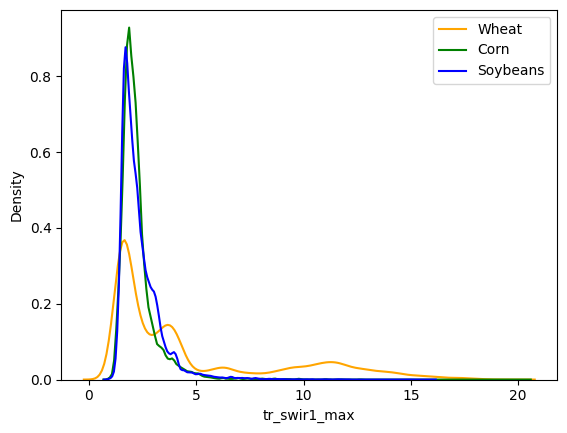

In [ ]:
target_var = "tr_swir1_max"
sns.kdeplot(data=df_wheat, x=target_var, color="orange")
sns.kdeplot(data=df_corn, x=target_var, color="green")
sns.kdeplot(data=df_soybeans, x=target_var, color="blue")
# add legend to the sns kdeplot
plt.legend(labels=["Wheat", "Corn", "Soybeans"])
# sns.kdeplot(data=df_soybeans, x=target_var)


In [ ]:
df_corn = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_corn_absolute_all_years.parquet")
df_soybeans = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_soybeans_absolute_all_years2.parquet")
df_wheat = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_wheat_absolute_all_years.parquet")

df_soybeans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 611229 entries, 0 to 55531
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   x                  611229 non-null  float64
 1   y                  611229 non-null  float64
 2   yield              611229 non-null  float64
 3   field              611229 non-null  object 
 4   year               611229 non-null  int64  
 5   elevation          611229 non-null  float32
 6   slope              611229 non-null  float32
 7   aspect             611229 non-null  float32
 8   ndvi_mean          611229 non-null  float64
 9   ndvi_max           611229 non-null  float64
 10  ndvi_range         611229 non-null  float64
 11  lst_median_k       611229 non-null  float64
 12  lst_range_k        611229 non-null  float64
 13  lst_max_k          611229 non-null  float64
 14  pr_season_mm       611229 non-null  float64
 15  pr_mean_mm_day     611229 non-null  float64
 16  pr_max_m

In [ ]:
df_soybeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611229 entries, 0 to 611228
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   x                  611229 non-null  float64
 1   y                  611229 non-null  float64
 2   yield              611229 non-null  float64
 3   field              611229 non-null  object 
 4   year               611229 non-null  int64  
 5   elevation          611229 non-null  float32
 6   slope              611229 non-null  float32
 7   aspect             611229 non-null  float32
 8   aspect_southness   611229 non-null  float32
 9   slope_squared      611229 non-null  float32
 10  elevation_squared  611229 non-null  float32
 11  elev_slope         611229 non-null  float32
 12  elev_aspect        611229 non-null  float32
 13  slope_aspect       611229 non-null  float32
 14  ndvi_mean          611229 non-null  float64
 15  ndvi_max           611229 non-null  float64
 16  nd

                     yield  elevation     slope    aspect  aspect_southness  \
yield             1.000000  -0.157670 -0.066300  0.027842          0.068333   
elevation        -0.157670   1.000000  0.282154 -0.074462         -0.092199   
slope            -0.066300   0.282154  1.000000  0.017655         -0.089222   
aspect            0.027842  -0.074462  0.017655  1.000000         -0.047837   
aspect_southness  0.068333  -0.092199 -0.089222 -0.047837          1.000000   
slope_squared    -0.022853   0.052204  0.582296  0.008248         -0.008651   
elev_slope       -0.094984   0.489345  0.915434 -0.008224         -0.087167   
elev_aspect      -0.015552   0.230382  0.096835  0.937057         -0.062590   
slope_aspect     -0.031551   0.138638  0.754153  0.567979         -0.100159   
ndvi_mean         0.180035  -0.088553  0.035751  0.057465          0.019644   
ndvi_max          0.180894  -0.086559  0.046094  0.032872          0.025165   
gcvi_mean        -0.011011   0.007771  0.001703  0.0

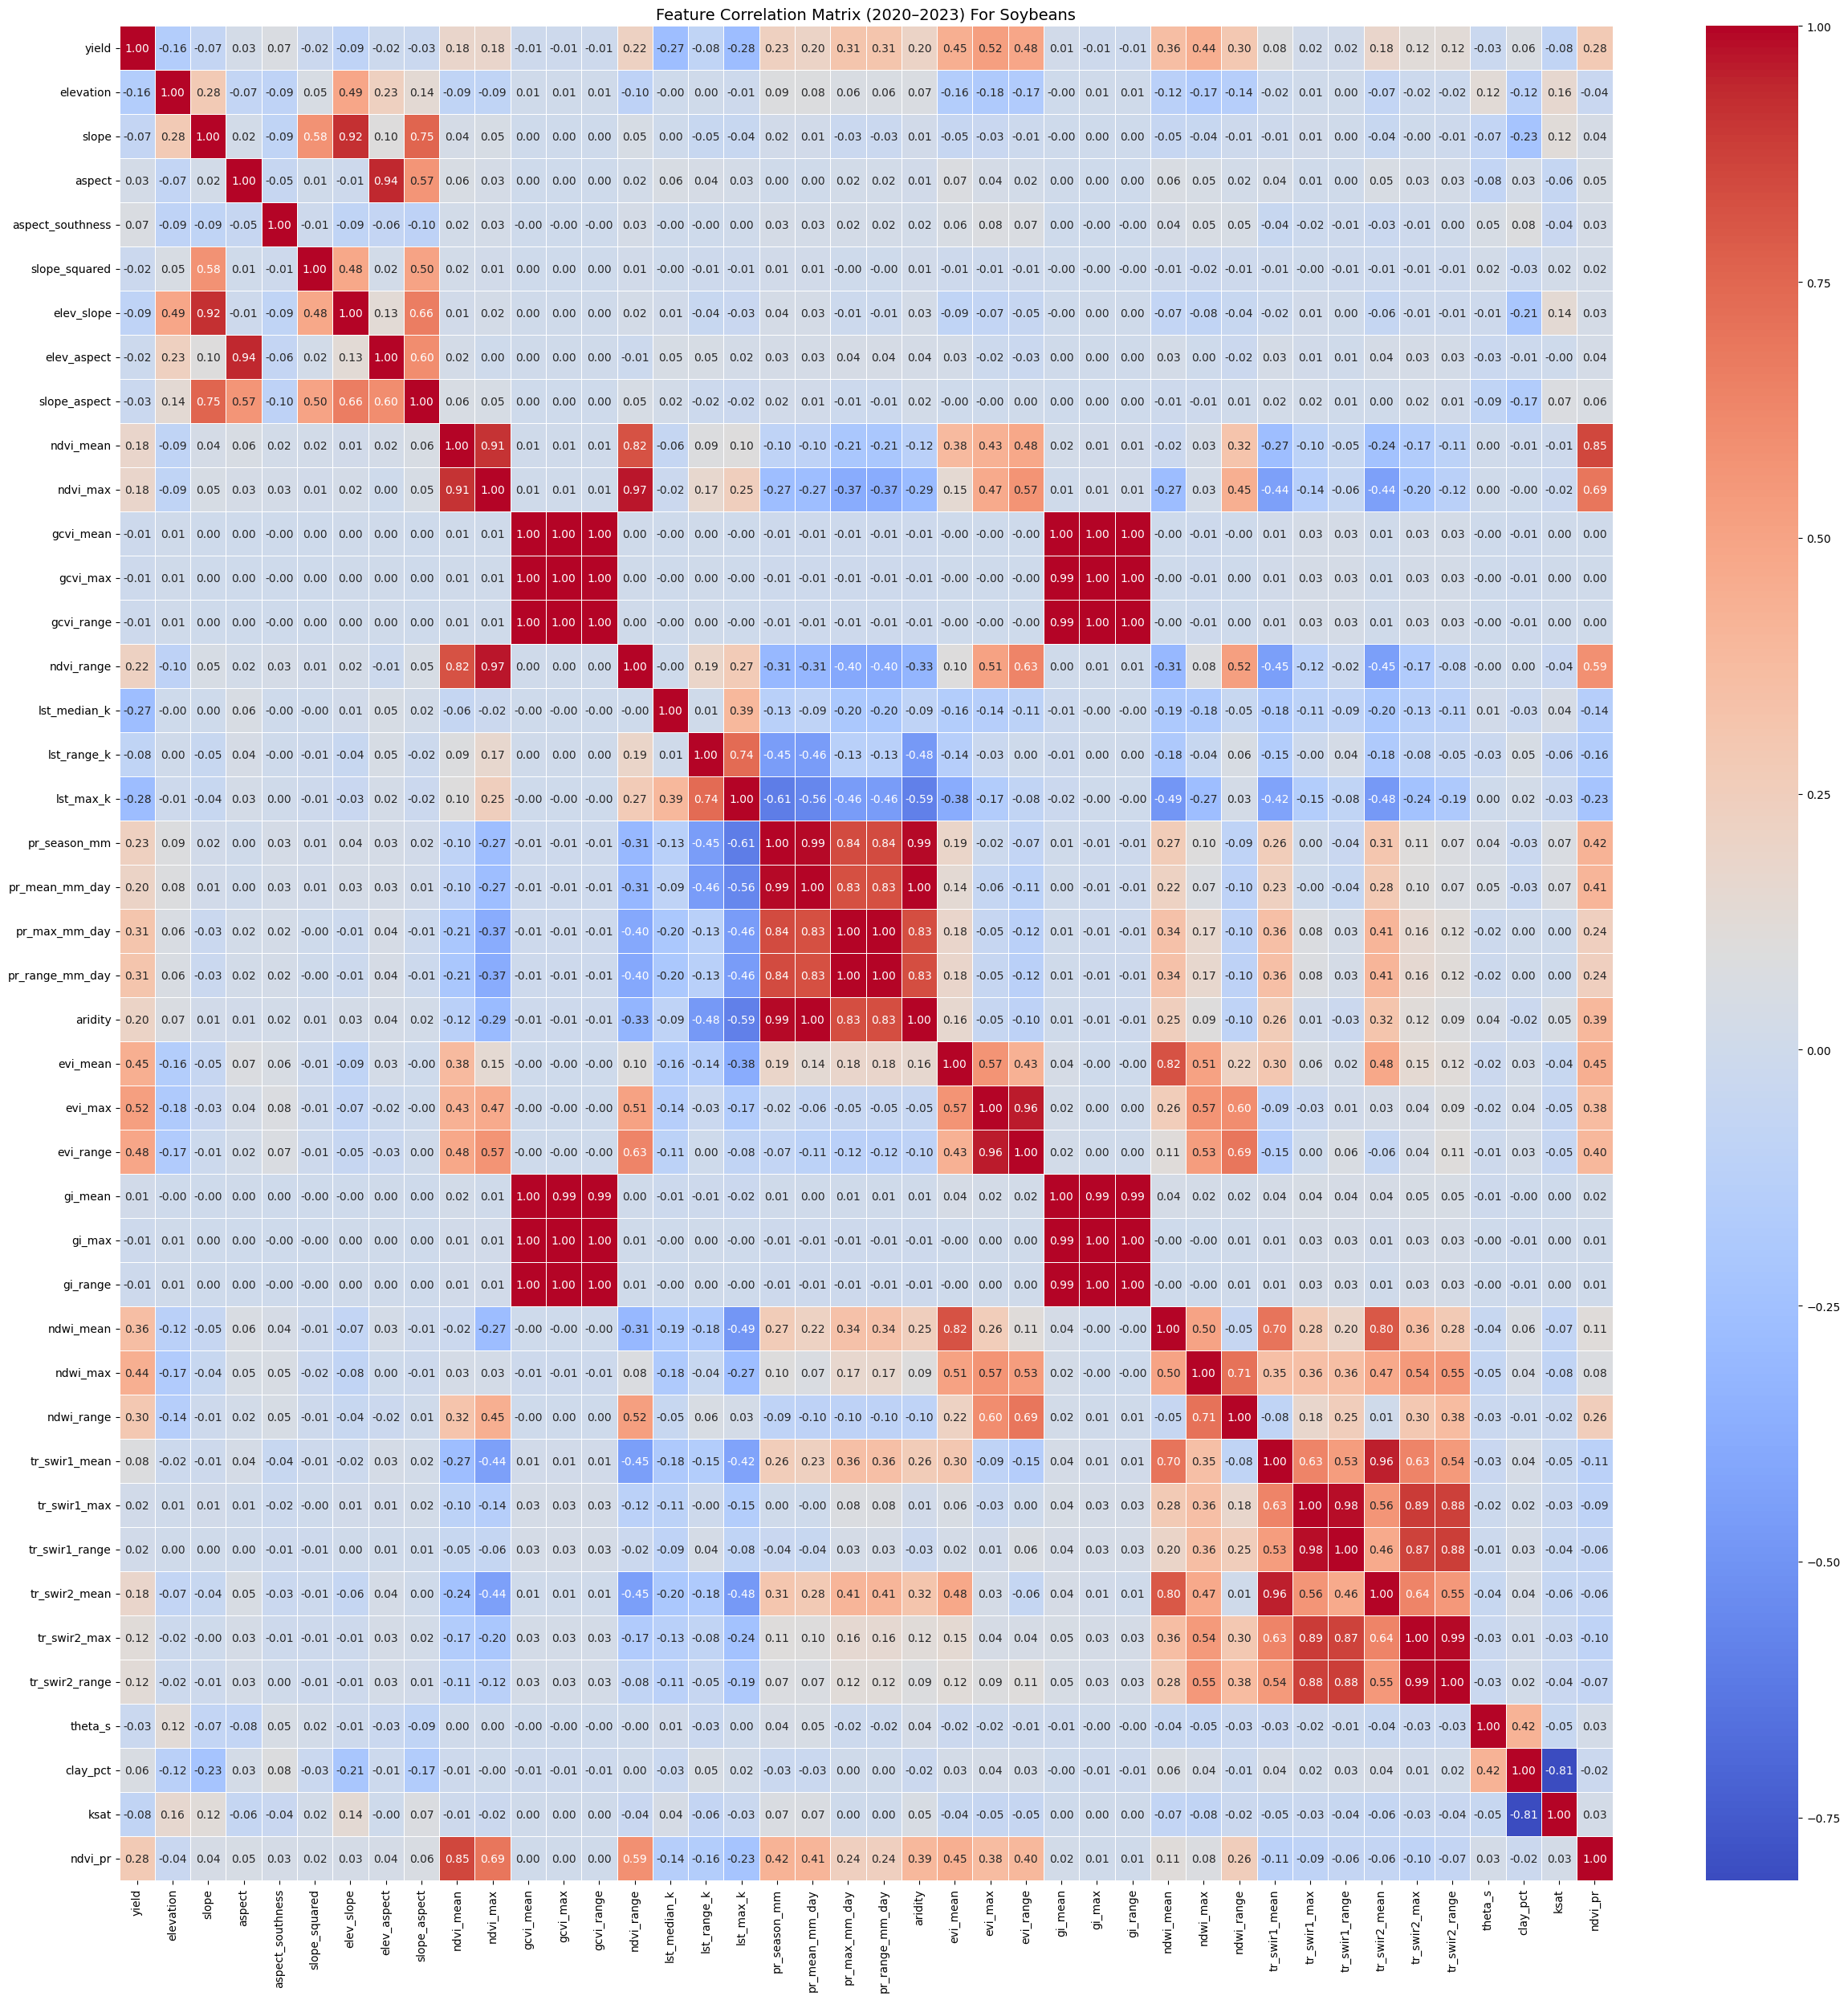

In [ ]:
# Build a Correlation Heatmap for all the variables
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ── choose your features ──────────────────────────────────────────
# corr_features = [
#     "elevation", "slope", "aspect",  "yield", "year", "slope_squared", "elevation_squared", "elev_slope", "elev_aspect", "ndvi_max", "ndvi_range",
#     "lst_mean_k", "lst_max_k", "lst_range_k", "pr_mean_mm_day", "pr_max_mm_day", "pr_range_mm_day",
#     "aspect_southness", "slope_aspect",
#     "ndvi_mean", "pr_season_mm", "aridity"
# ]

corr_features = ['yield', 'elevation', 'slope',
       'aspect', 'aspect_southness', 'slope_squared',
       'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_mean', 'ndvi_max',
                 'gcvi_mean', 'gcvi_max', 'gcvi_range',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max',
       'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range', 'tr_swir1_mean',
       'tr_swir1_max', 'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max',
       'tr_swir2_range', 'theta_s', 'clay_pct', 'ksat', 'ndvi_pr',
                 ]

# ── select only those columns from the dataframe ─────────────────
df_features = df_soybeans[corr_features]

# ── compute correlation matrix ───────────────────────────────────
corr_matrix = df_features.corr()

# ── print raw numbers ────────────────────────────────────────────
print(corr_matrix)

# ── plot heatmap ─────────────────────────────────────────────────
plt.figure(figsize=(30, 30))
sns.heatmap(
    corr_matrix,
    annot=True,        # show correlation values
    cmap="coolwarm",   # color scheme
    fmt=".2f",         # format decimals
    linewidths=0.5
)
plt.title("Feature Correlation Matrix (2020–2023) For Soybeans", fontsize=14)
plt.show()


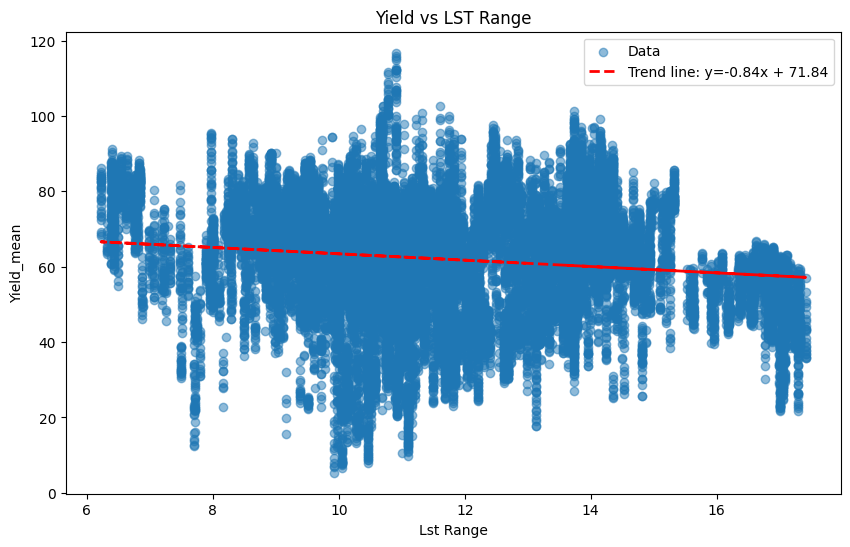

In [ ]:
#Plot yield values against the NDVI mean values and add a line that represents the trend
#also plot a line that describes the trend of the yield and ndvi graph
import numpy as np
import matplotlib.pyplot as plt

# Extract data
# mask = (df_map["2014-2024"]['field'] == "Central Farm_1-14A") & (df_map["2014-2024"]['year'] == 2014)
mask = (df_map["2014-2024"]['year'] == 2014)
x = df_map["2014-2024"][mask]["lst_range_k"]
y = df_map["2014-2024"][mask]["yield"]

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, label="Data")

# Fit a linear regression line
z = np.polyfit(x, y, 1)   # degree=1 for linear
p = np.poly1d(z)

# Plot the regression line
plt.plot(x, p(x), "r--", linewidth=2, label=f"Trend line: y={z[0]:.2f}x + {z[1]:.2f}")

plt.title("Yield vs LST Range")
plt.xlabel("Lst Range")
plt.ylabel("Yield_mean")
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# ==== USER SETTINGS (edit these) ============================================
target_col = "yield"
# If you already have features as a dict, just flatten it here:
# features = sorted({f for lst in features.values() for f in lst})
# Otherwise, provide a simple list:
features = ['elevation', 'slope',
       'aspect', 'aspect_southness', 'slope_squared',
       'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_mean', 'ndvi_max',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max',
       'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range', 'tr_swir1_mean',
       'tr_swir1_max', 'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max',
       'tr_swir2_range', 'theta_s', 'clay_pct', 'ksat', 'ndvi_pr']
# NOTE: If you already have `features` defined above, you can delete this line.
features = list(features)  # works if features is a list; flattens if it's a set

corr_threshold   = 0.80    # max allowed |pairwise corr| among kept features
min_target_corr  = 0.05    # ignore features with |corr to yield| below this
corr_method      = "pearson"  # change to "spearman" if you prefer rank correlation
drop_rows_with_na = True
# ============================================================================

def select_low_collinear_high_target(df, features, target, corr_threshold=0.8,
                                     min_target_corr=0.0, method="pearson",
                                     dropna=True):
    # Keep only columns we need and coerce to numeric
    cols = [c for c in features + [target] if c in df.columns]
    num = df[cols].apply(pd.to_numeric, errors="coerce")
    if dropna:
        num = num.dropna(subset=cols)

    # 1) correlation with target (absolute, descending)
    corr_to_target = num.corr(method=method)[target].drop(labels=[target]).abs()
    corr_to_target = corr_to_target.dropna().sort_values(ascending=False)

    # optional floor so we ignore super-weak predictors
    candidates = [f for f, r in corr_to_target.items() if r >= min_target_corr]
    if not candidates:
        return [], corr_to_target, pd.DataFrame(), pd.DataFrame(), {}

    # 2) pairwise correlation among candidates
    pair_abs = num[candidates].corr(method=method).abs()

    # 3) greedy keep: walk from strongest-to-yield downward
    kept = []
    dropped_because = {}
    for f in candidates:
        # if f is too correlated with something we already kept, drop it
        if any(pair_abs.loc[f, k] > corr_threshold for k in kept):
            # record which kept feature caused the drop (highest offending corr)
            # (helpful for auditing)
            conflicter = max(kept, key=lambda k: pair_abs.loc[f, k])
            dropped_because[f] = conflicter
            continue
        kept.append(f)

    # 4) nice-to-have: a compact table of high-corr pairs (for inspection)
    tri = np.triu(np.ones(pair_abs.shape), 1).astype(bool)
    high_pairs = (
        pair_abs.where(tri)
        .stack()
        .rename("abs_corr")
        .reset_index()
        .rename(columns={"level_0": "feat_a", "level_1": "feat_b"})
        .query("abs_corr > @corr_threshold")
        .sort_values("abs_corr", ascending=False)
        .reset_index(drop=True)
    )

    return kept, corr_to_target, pair_abs, high_pairs, dropped_because

# ==== RUN ON df_soybeans =====================================================
kept, corr_to_yield, pairwise_abs, high_pairs, dropped_map = select_low_collinear_high_target(
    df=df_wheat,
    features=features,
    target=target_col,
    corr_threshold=corr_threshold,
    min_target_corr=min_target_corr,
    method=corr_method,
    dropna=drop_rows_with_na
)

# ==== OUTPUTS YOU'LL LIKELY WANT ============================================
print("Selected (kept) features:")
print(kept)

print("\nAbsolute correlation with yield (sorted):")
print(corr_to_yield.loc[kept + [f for f in corr_to_yield.index if f not in kept]])

print("\nDropped features and the kept feature they conflicted with:")
print(dropped_map)

print("\nHighly correlated feature pairs (>|threshold|) among candidates:")
print(high_pairs)


Selected (kept) features:
['evi_max', 'ndvi_max', 'ndvi_mean', 'ndwi_range', 'evi_mean', 'pr_range_mm_day', 'lst_max_k', 'elev_slope', 'elevation', 'ksat', 'clay_pct', 'slope_aspect', 'aridity', 'lst_median_k', 'tr_swir1_mean', 'aspect_southness', 'elev_aspect']

Absolute correlation with yield (sorted):
evi_max             0.329162
ndvi_max            0.311903
ndvi_mean           0.272177
ndwi_range          0.241647
evi_mean            0.185878
pr_range_mm_day     0.133353
lst_max_k           0.121346
elev_slope          0.117016
elevation           0.114627
ksat                0.107306
clay_pct            0.105238
slope_aspect        0.101138
aridity             0.095560
lst_median_k        0.088176
tr_swir1_mean       0.079541
aspect_southness    0.073685
elev_aspect         0.054759
evi_range           0.320571
ndvi_range          0.305666
ndvi_pr             0.235122
ndwi_max            0.231509
pr_max_mm_day       0.133353
ndwi_mean           0.121920
slope               0.11692

['evi_max', 'evi_mean', 'ndwi_max', 'pr_range_mm_day', 'ndwi_range', 'ndvi_pr', 'lst_max_k', 'lst_median_k', 'ndvi_range', 'tr_swir2_mean', 'elevation', 'tr_swir2_range', 'elev_slope', 'lst_range_k', 'ksat', 'aspect_southness']


['ndwi_max', 'ndwi_range', 'evi_max', 'evi_mean', 'tr_swir2_range', 'tr_swir2_mean', 'ndvi_range', 'lst_median_k', 'lst_max_k', 'ndvi_pr', 'elevation', 'lst_range_k', 'gi_mean', 'elev_aspect']

['evi_max', 'ndvi_max', 'ndvi_mean', 'ndwi_range', 'evi_mean', 'pr_range_mm_day', 'lst_max_k', 'elev_slope', 'elevation', 'ksat', 'clay_pct', 'slope_aspect', 'aridity', 'lst_median_k', 'tr_swir1_mean', 'aspect_southness', 'elev_aspect']





In [ ]:
# === Baseline RF -> Reduced RF + RandomizedSearchCV (Leave-One-Year-Out CV) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, GroupKFold, KFold
from sklearn.model_selection import GroupShuffleSplit  # add at top with other imports

# ---------------- USER CONFIG ----------------
field_name = "Central Farm_2-71"
df_yield = df_soybeans                   # <- your dataframe
target_col = "yield"
target_year = 2022                       # test year

# Full feature list
features = [
    'elevation', 'slope', 'aspect',
    'ndvi_mean', 'ndvi_max', 'ndvi_range', 'lst_median_k', 'lst_range_k',
    'lst_max_k', 'pr_season_mm',  'pr_max_mm_day',
    'pr_range_mm_day', 'aridity', 'theta_s', 'clay_pct', 'ksat', 'evi_mean',
    'evi_max', 'evi_range', 'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean',
    'ndwi_max', 'ndwi_range', 'tr_swir1_mean', 'tr_swir1_max',
    'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range',
    'slope_aspect', 'ndvi_pr', 'aspect_southness'
]

# Feature filtering controls
importance_threshold = 0.01
top_k = None
min_keep = 10

# RandomizedSearchCV controls
do_random_search = True
n_iter = 60
scoring = "neg_mean_absolute_error"
random_state = 42
verbose = 1

# ---------------- DATA -------------------
print("=================================================")
print(field_name)
print("=================================================")

df_field = df_yield[df_yield["field"] == field_name].copy()
train = df_field[df_field["year"] != target_year]
test  = df_field[df_field["year"] == target_year]

X_train, y_train = train[features], train[target_col]
X_test,  y_test  = test[features],  test[target_col]

print(f"Training years: {sorted(train['year'].unique().tolist())}")
print(f"Testing year: {target_year}")
print(f"#Train: {X_train.shape}, #Test: {X_test.shape}")

# ---------------- HELPERS ----------------
def metrics(y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    # Pearson correlation coefficient between actual and predicted
    r   = float(np.corrcoef(np.asarray(y_true), np.asarray(y_pred))[0, 1])
    return r2, mae, r

# ---------------- BASELINE MODEL (all features) -----------------
rf_base = RandomForestRegressor(n_estimators=200, random_state=random_state, n_jobs=-1)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)
r2_b, mae_b, r_b = metrics(y_test, y_pred_base)

print("\n=== Baseline (all features) ===")
print(f"R²   : {r2_b:.4f}")
print(f"MAE  : {mae_b:.4f}")
print(f"Corr : {r_b:.4f}")

# ---------------- FEATURE FILTERING ----------------
imp_df = pd.DataFrame({
    "feature": features,
    "importance": rf_base.feature_importances_
}).sort_values("importance", ascending=False)

if top_k is not None:
    keep_feats = imp_df.head(top_k)["feature"].tolist()
else:
    keep_feats = imp_df[imp_df["importance"] >= importance_threshold]["feature"].tolist()
    if len(keep_feats) < min_keep:
        keep_feats = imp_df.head(min_keep)["feature"].tolist()

print(f"\nSelected features ({len(keep_feats)}): {keep_feats}")

# ---------------- REDUCED MODEL (no tuning) ----------------
rf_red = RandomForestRegressor(n_estimators=300, random_state=random_state, n_jobs=-1)
rf_red.fit(X_train[keep_feats], y_train)
y_pred_red = rf_red.predict(X_test[keep_feats])
r2_r, mae_r, r_r = metrics(y_test, y_pred_red)  # (we compute r_r, but you asked to report r for baseline + final)

print("\n=== Reduced model (filtered features, no tuning) ===")
print(f"R²   : {r2_r:.4f}   (Δ vs baseline: {r2_r - r2_b:+.4f})")
print(f"MAE  : {mae_r:.4f}  (Δ vs baseline: {mae_r - mae_b:+.4f})")

# ---------------- RANDOMIZED SEARCH CV (Leave-One-Year-Out) ----------------
y_pred_tuned = None
r2_t, mae_t, r_t = None, None, None
best_params = None

if do_random_search:
    uniq_years = sorted(train["year"].unique().tolist())
    if len(uniq_years) >= 2:
        cv = GroupKFold(n_splits=len(uniq_years))   # one fold per year
        groups = train["year"].values
    else:
        cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
        groups = None

    # param_distributions = {
    #     "n_estimators": np.linspace(300, 1200, 10, dtype=int),
    #     "max_depth": [None] + list(range(5, 40, 5)),
    #     "min_samples_split": [2, 5, 10, 20, 50],
    #     "min_samples_leaf": [1, 2, 5, 10, 20, 50],
    #     "max_features": ["sqrt", "log2", 0.5, 0.7, 0.9],
    #     "bootstrap": [True],
    #     "max_samples": [None] + list(np.round(np.linspace(0.6, 1.0, 5), 2)),
    #     "criterion": ["squared_error"],
    # }


    param_distributions = {
                                "n_estimators": np.linspace(400, 1200, 9, dtype=int),
                                "max_depth": [None] + list(range(10, 41, 5)),
                                "min_samples_split": [2, 5, 10, 20],
                                "min_samples_leaf": [1, 2, 4, 8],
                                "max_features": ["sqrt", "log2", 0.6, 0.8, 1.0],
                                "bootstrap": [True],
                                "max_samples": [None, 0.8, 1.0],
                                "max_leaf_nodes": [None, 256, 512],
                                "criterion": ["squared_error"],
                              }




    base_est = RandomForestRegressor(random_state=random_state, n_jobs=-1)

    rs = RandomizedSearchCV(
        estimator=base_est,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring=scoring,
        cv=GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state),
        random_state=random_state,
        n_jobs=-1,
        verbose=verbose,
        refit=True
    )

    print("\n>>> Running RandomizedSearchCV (leave-one-year-out) on reduced feature set...")
    if groups is None:
        rs.fit(X_train[keep_feats], y_train)
    else:
        rs.fit(X_train[keep_feats], y_train, groups=groups)

    best_params = rs.best_params_
    best_cv = rs.best_score_
    print("\n=== Best CV result (reduced features) ===")
    print(f"{scoring}: {best_cv:.4f}")
    print("Best params:", best_params)

    y_pred_tuned = rs.best_estimator_.predict(X_test[keep_feats])
    r2_t, mae_t, r_t = metrics(y_test, y_pred_tuned)
    print("\n=== Tuned Reduced model (held-out year) ===")
    print(f"R²   : {r2_t:.4f}   (Δ vs reduced: {r2_t - r2_r:+.4f}, Δ vs baseline: {r2_t - r2_b:+.4f})")
    print(f"MAE  : {mae_t:.4f}  (Δ vs reduced: {mae_t - mae_r:+.4f}, Δ vs baseline: {mae_t - mae_b:+.4f})")
    print(f"Corr : {r_t:.4f}")

# ---------------- PLOTS ----------------
# 0) Feature importance (unchanged)
plt.figure(figsize=(9,6))
top = min(20, len(imp_df))
plt.bar(range(top), imp_df["importance"].values[:top])
plt.xticks(range(top), imp_df["feature"].values[:top], rotation=60, ha="right")
plt.title("Baseline RF Feature Importance (top 20)")
plt.tight_layout()
plt.show()

# 1) Baseline-only scatter
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_base, alpha=0.55, label=f"Baseline\nR²={r2_b:.3f}, MAE={mae_b:.2f}, r={r_b:.3f}")
lims = [min(y_test.min(), y_pred_base.min()), max(y_test.max(), y_pred_base.max())]
plt.plot(lims, lims, "k--")
plt.xlim(lims); plt.ylim(lims)
plt.xlabel(f"Actual ({target_year})"); plt.ylabel("Predicted")
plt.title(f"{field_name} — Baseline ({target_year})")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Reduced-tuned scatter
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_tuned, alpha=0.55, label=f"Reduced and Tuned \nR²={r2_t:.3f}, MAE={mae_t:.2f}")
lims = [min(y_test.min(), y_pred_tuned.min()), max(y_test.max(), y_pred_tuned.max())]
plt.plot(lims, lims, "k--")
plt.xlim(lims); plt.ylim(lims)
plt.xlabel(f"Actual ({target_year})"); plt.ylabel("Predicted")
plt.title(f"{field_name} — Reduced and Tuned ({target_year})")
plt.legend()
plt.tight_layout()
plt.show()

# 3) Combined scatter (as you had)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_base, alpha=0.55, label="Baseline")
# plt.scatter(y_test, y_pred_red,  alpha=0.45, label="Reduced")
if y_pred_tuned is not None:
    plt.scatter(y_test, y_pred_tuned, alpha=0.35, label=f"Reduced (Tuned)\nr={r_t:.3f}")
lims = [min(y_test.min(),
            y_pred_base.min(),
            y_pred_red.min(),
            y_pred_tuned.min() if y_pred_tuned is not None else y_pred_red.min()),
        max(y_test.max(),
            y_pred_base.max(),
            y_pred_red.max(),
            y_pred_tuned.max() if y_pred_tuned is not None else y_pred_red.max())]
plt.plot(lims, lims, "k--")
plt.xlim(lims); plt.ylim(lims)
plt.xlabel(f"Actual ({target_year})"); plt.ylabel("Predicted")
plt.title(f"{field_name} — {target_year} Predictions")
plt.legend()
plt.tight_layout()
plt.show()


Central Farm_2-71
Training years: [2014, 2015, 2016, 2017, 2018, 2021, 2024]
Testing year: 2022
#Train: (30754, 34), #Test: (5841, 34)

=== Baseline (all features) ===
R²   : -0.6454
MAE  : 9.7994
Corr : 0.8047

Selected features (16): ['lst_range_k', 'ndvi_max', 'gi_max', 'elevation', 'ndvi_range', 'evi_range', 'gi_range', 'slope', 'theta_s', 'lst_max_k', 'lst_median_k', 'ndwi_mean', 'tr_swir1_mean', 'ndvi_pr', 'ndvi_mean', 'tr_swir2_mean']

=== Reduced model (filtered features, no tuning) ===
R²   : -0.6150   (Δ vs baseline: +0.0305)
MAE  : 9.6361  (Δ vs baseline: -0.1633)

>>> Running RandomizedSearchCV (leave-one-year-out) on reduced feature set...
Fitting 1 folds for each of 60 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

Train: (30754, 44), Test: (5841, 44)

=== Model 1 (Features1) ===
R²   : -0.6613
MAE  : 9.8694
Corr : 0.8049


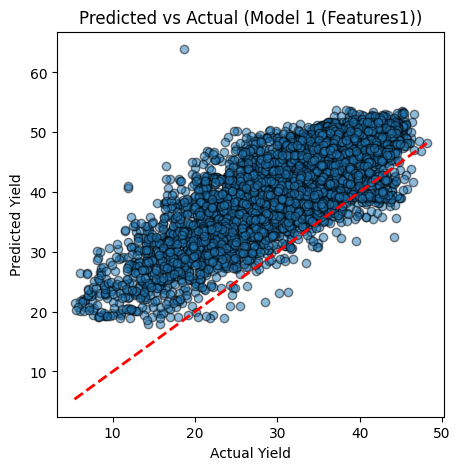


=== Model 2 (Features2) ===
R²   : -0.4371
MAE  : 8.6121
Corr : 0.6467


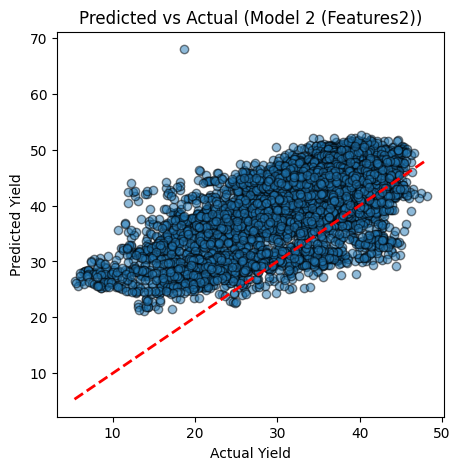

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# ===============================
# 1. CONFIG
# ===============================
field_name = "Central Farm_2-71"
target_col = "yield"
test_year = 2022

# Feature lists
features1 = [
    'elevation', 'slope', 'aspect',
    'ndvi_mean', 'ndvi_max', 'ndvi_range', 'lst_median_k', 'lst_range_k',
    'lst_max_k', 'pr_season_mm',  'pr_max_mm_day',
    'pr_range_mm_day', 'aridity', 'theta_s', 'clay_pct', 'ksat', 'evi_mean',
    'evi_max', 'evi_range', 'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean',
    'ndwi_max', 'ndwi_range', 'tr_swir1_mean', 'tr_swir1_max',
    'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range',
    'slope_aspect', 'ndvi_pr', 'aspect_southness'
]
features2 = ['evi_max', 'evi_mean', 'ndwi_max', 'pr_range_mm_day', 'ndwi_range', 'ndvi_pr', 'lst_max_k', 'lst_median_k', 'ndvi_range', 'tr_swir2_mean', 'elevation', 'tr_swir2_range', 'elev_slope', 'lst_range_k', 'ksat', 'aspect_southness'
]

# ===============================
# 2. FILTER DATA
# ===============================
df_field = df_soybeans[df_soybeans["field"] == field_name].copy()

train_df = df_field[df_field["year"] != test_year]
test_df  = df_field[df_field["year"] == test_year]

print(f"Train: {train_df.shape}, Test: {test_df.shape}")

# ===============================
# 3. TRAIN AND EVALUATE FUNCTION
# ===============================
def train_and_evaluate(features, train_df, test_df, label):
    X_train, y_train = train_df[features], train_df[target_col]
    X_test, y_test   = test_df[features], test_df[target_col]

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    corr = np.corrcoef(y_test, y_pred)[0, 1]

    print(f"\n=== {label} ===")
    print(f"R²   : {r2:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"Corr : {corr:.4f}")

    # Scatter plot
    plt.figure(figsize=(5, 5))
    plt.scatter(y_test, y_pred, alpha=0.5, edgecolor="k")
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             "r--", lw=2)
    plt.xlabel("Actual Yield")
    plt.ylabel("Predicted Yield")
    plt.title(f"Predicted vs Actual ({label})")
    plt.show()

    return model

# ===============================
# 4. RUN BOTH MODELS
# ===============================
model1 = train_and_evaluate(features1, train_df, test_df, "Model 1 (Features1)")
model2 = train_and_evaluate(features2, train_df, test_df, "Model 2 (Features2)")


Train: (30754, 44), Test: (5841, 44)
Model 1 (ALL features) — Pred vs Actual
R²   : -0.6613
MAE  : 9.8694
Corr : 0.8049


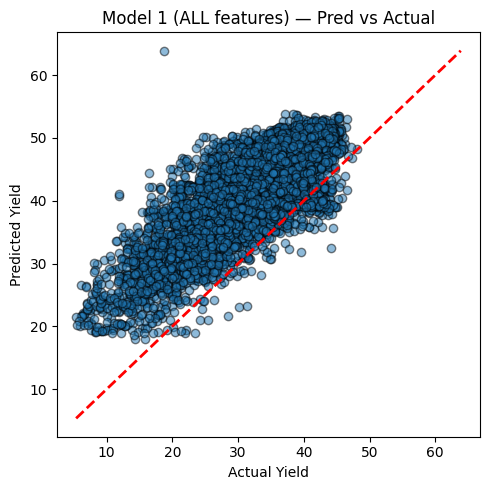


Top importances (ALL features model):
lst_range_k         0.472321
ndvi_max            0.081901
gi_max              0.078781
elevation           0.057116
ndvi_range          0.043042
evi_range           0.029661
gi_range            0.025474
slope               0.017830
theta_s             0.015157
lst_max_k           0.014563
ndwi_mean           0.013507
lst_median_k        0.012108
ndvi_mean           0.011242
tr_swir1_mean       0.010999
ndvi_pr             0.010771
tr_swir2_mean       0.010466
aspect_southness    0.009800
gi_mean             0.008699
slope_aspect        0.008563
evi_max             0.007649
dtype: float64

Selected features (≥1% importance) [n=16]:
['lst_range_k', 'ndvi_max', 'gi_max', 'elevation', 'ndvi_range', 'evi_range', 'gi_range', 'slope', 'theta_s', 'lst_max_k', 'ndwi_mean', 'lst_median_k', 'ndvi_mean', 'tr_swir1_mean', 'ndvi_pr', 'tr_swir2_mean']
Model 1 (≥1% importance features) — Pred vs Actual
R²   : -0.5920
MAE  : 9.5503
Corr : 0.7547


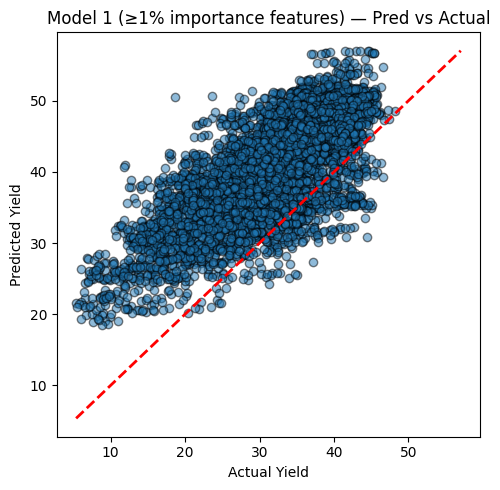

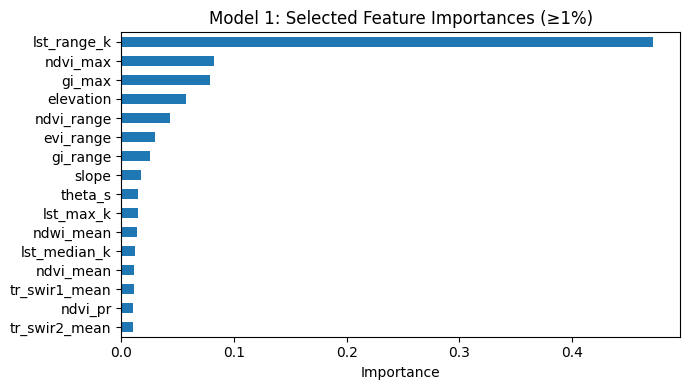

Model 2 (given feature list) — Pred vs Actual
R²   : -1.6812
MAE  : 12.2640
Corr : 0.6749


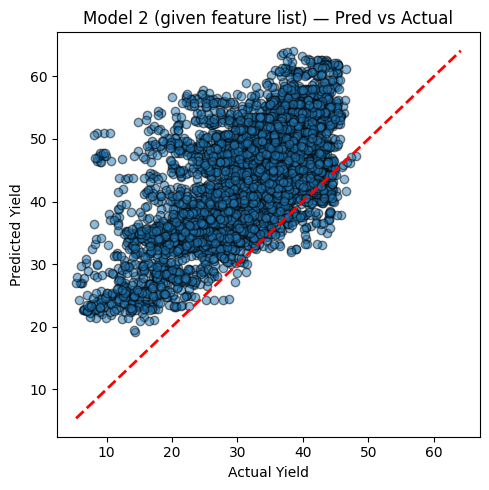

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# ===============================
# 0) CONFIG
# ===============================
field_name = "Central Farm_2-71"
target_col = "yield"
test_year = 2022

# Model 2 feature list (unchanged)
features2 = [
    'evi_mean', 'evi_max', 'evi_range',
    'gi_mean', 'gi_max', 'gi_range',
    'ndwi_mean', 'ndwi_max', 'ndwi_range',
    'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range',
    'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range',
    'slope_aspect', 'ndvi_pr', 'aspect_southness'
]

# FULL feature list for Model 1 (union of your two lists)
all_features = [
    'elevation', 'slope', 'aspect',
    'ndvi_mean', 'ndvi_max', 'ndvi_range', 'lst_median_k', 'lst_range_k',
    'lst_max_k', 'pr_season_mm',  'pr_max_mm_day', 'pr_range_mm_day',
    'aridity', 'theta_s', 'clay_pct', 'ksat',
    'evi_mean', 'evi_max', 'evi_range',
    'gi_mean', 'gi_max', 'gi_range',
    'ndwi_mean', 'ndwi_max', 'ndwi_range',
    'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range',
    'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range',
    'slope_aspect', 'ndvi_pr', 'aspect_southness'
]
# de-duplicate while preserving order
all_features = list(dict.fromkeys(all_features))

# ===============================
# 1) FILTER DATA (field + temporal split)
# ===============================
df_field = df_soybeans[df_soybeans["field"] == field_name].copy()
train_df = df_field[df_field["year"] != test_year]
test_df  = df_field[df_field["year"] == test_year]

print(f"Train: {train_df.shape}, Test: {test_df.shape}")
assert len(test_df) > 0, "No 2022 rows found for this field."

# Helper: metrics + scatter
def evaluate_and_plot(y_true, y_pred, title=""):
    r2  = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[0, 1]

    print(f"{title}")
    print(f"R²   : {r2:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"Corr : {corr:.4f}")

    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolor="k")
    xy_min, xy_max = float(np.min([y_true.min(), y_pred.min()])), float(np.max([y_true.max(), y_pred.max()]))
    plt.plot([xy_min, xy_max], [xy_min, xy_max], "r--", lw=2)
    plt.xlabel("Actual Yield")
    plt.ylabel("Predicted Yield")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return {"r2": r2, "mae": mae, "corr": corr}

# ===============================
# 2) MODEL 1 — Base RF on ALL FEATURES, then prune by ≥1% importance and retrain
# ===============================
Xtr_all = train_df[all_features]
ytr     = train_df[target_col]
Xte_all = test_df[all_features]
yte     = test_df[target_col]

# Base model (no tuning)
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(Xtr_all, ytr)
pred_base = rf_base.predict(Xte_all)
_ = evaluate_and_plot(yte, pred_base, title="Model 1 (ALL features) — Pred vs Actual")

# Feature importance
fi = pd.Series(rf_base.feature_importances_, index=all_features).sort_values(ascending=False)
print("\nTop importances (ALL features model):")
print(fi.head(20))

# Select features with >= 1% importance
selected_feats = fi[fi >= 0.01].index.tolist()
print(f"\nSelected features (≥1% importance) [n={len(selected_feats)}]:")
print(selected_feats)

# Safety guard: if none meet threshold, fall back to top-10
if len(selected_feats) == 0:
    selected_feats = fi.head(10).index.tolist()
    print("\nNo features ≥1%. Falling back to top-10 by importance:")
    print(selected_feats)

# Retrain with reduced set
Xtr_sel = train_df[selected_feats]
Xte_sel = test_df[selected_feats]

rf_pruned = RandomForestRegressor(random_state=42)
rf_pruned.fit(Xtr_sel, ytr)
pred_pruned = rf_pruned.predict(Xte_sel)
_ = evaluate_and_plot(yte, pred_pruned, title="Model 1 (≥1% importance features) — Pred vs Actual")

# (Optional) quick bar plot of selected importances
plt.figure(figsize=(7,4))
fi[selected_feats].sort_values().plot(kind="barh")
plt.title("Model 1: Selected Feature Importances (≥1%)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# ===============================
# 3) MODEL 2 — unchanged (your second feature list)
# ===============================
Xtr_m2 = train_df[features2]
Xte_m2 = test_df[features2]

rf_m2 = RandomForestRegressor(random_state=42)
rf_m2.fit(Xtr_m2, ytr)
pred_m2 = rf_m2.predict(Xte_m2)
_ = evaluate_and_plot(yte, pred_m2, title="Model 2 (given feature list) — Pred vs Actual")
